# 분류 실습 - 캐글 산탄데르 고객 만족 예측
### 고객 만족 여부를 XGBoost와 lightGBM을 활용해 예측
- 피처 명은 익명, 레이블 명은 TARGET
- TARGET = 1 : 불만을 가진 고객
- TARGET = 0 : 만족한 고객
- 모델의 성능 평가는 ROC-AUC 곡선으로 평가

## 1. 데이터 전처리

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

cust_df = pd.read_csv(r'C:\Users\ADMIN\PycharmProjects\ESAA\data\santander-customer-satisfaction\train_santander.csv', encoding = 'latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head()

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [3]:
# 피처의 타입과 Null 값 확인
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [4]:
# 레이블 분포도 확인
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET'] == 1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt / total_cnt)))

0    73012
1     3008
Name: TARGET, dtype: int64
unsatisfied 비율은 0.04


In [5]:
# 피처의 값 분포 확인
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [6]:
# var3의 -999999를 2로 변환
cust_df['var3'].replace(-999999, 2, inplace = True)
# ID 피처를 삭제
cust_df.drop('ID', axis = 1, inplace = True)

# 피처 세트와 레이블 세트 분리. 레이블 칼럼은 DataFrame의 맨 마지막에 위치해 칼럼 위치 -1로 분리
X_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]
print('피처 데이터 shape:{0}'.format(X_features.shape))

피처 데이터 shape:(76020, 369)


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels,
                                                    test_size = 0.2, random_state = 0)

train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape, X_test.shape))

print('학습 세트 레이블 값 분포 비율')
print(y_train.value_counts() / train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts() / test_cnt)

학습 세트 Shape:(60816, 369), 테스트 세트 Shape:(15204, 369)
학습 세트 레이블 값 분포 비율
0    0.960964
1    0.039036
Name: TARGET, dtype: float64

 테스트 세트 레이블 값 분포 비율
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


## 2. XGBoost 모델 학습과 하이퍼 파라미터 튜닝
- XGBoost의 학습 모델 생성
- 예측 결과를 ROC-AUC로 평가

In [8]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# n_estimators는 500, random_state는 예제 수행 시마다 동일 예측 결과를 위해 설정
xgb_clf = XGBClassifier(n_estimators = 500, random_stae = 156)

# 성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행
xgb_clf.fit(X_train, y_train, early_stopping_rounds = 100,
            eval_metric = 'auc', eval_set = [(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1], average = 'macro')
print('ROC AUC:{0:.4f}'.format(xgb_roc_score))

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:13:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "random_stae" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.82005	validation_1-auc:0.81157
[1]	validation_0-auc:0.83400	validation_1-auc:0.82452
[2]	validation_0-auc:0.83870	validation_1-auc:0.82746
[3]	validation_0-auc:0.84419	validation_1-auc:0.82922
[4]	validation_0-auc:0.84783	validation_1-auc:0.83298
[5]	validation_0-auc:0.85125	validation_1-auc:0.83500
[6]	validation_0-auc:0.85501	validation_1-auc:0.83653
[7]	validation_0-auc:0.85831	validation_1-auc:0.83782
[8]	validation_0-auc:0.86143	validation_1-auc:0.83802
[9]	validation_0-auc:0.86452	validation_1-auc:0.83914
[10]	validation_0-auc:0.86717	validation

In [12]:
# XGBoost의 하이퍼 파라미터 튜닝
# max_depth, min_child_weight, colsample_bytree 하이퍼 파라미터만 일차 튜닝
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 100으로 감소
xgb_clf = XGBClassifier(n_estimators = 100)

params = {'max_depth':[5, 7], 'min_child_weight':[1, 3], 'colsample_bytree':[0.5, 0.75]}

# cv는 3으로 지정
gridcv = GridSearchCV(xgb_clf, param_grid = params, cv = 3)
gridcv.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric = 'auc',
           eval_set = [(X_train, y_train), (X_test, y_test)])

print('GridSearchCV 최적 파라미터:', gridcv.best_params_)

xgb_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:, 1], average = 'macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.79161	validation_1-auc:0.79321
[1]	validation_0-auc:0.81865	validation_1-auc:0.81375
[2]	validation_0-auc:0.82586	validation_1-auc:0.81846
[3]	validation_0-auc:0.82789	validation_1-auc:0.82226
[4]	validation_0-auc:0.83249	validation_1-auc:0.82677
[5]	validation_0-auc:0.83477	validation_1-auc:0.83225
[6]	validation_0-auc:0.83340	validation_1-auc:0.82654
[7]	validation_0-auc:0.84223	validation_1-auc:0.83486
[8]	validation_0-auc:0.84586	validation_1-auc:0.83682
[9]	validation_0-auc:0.84557	validation_1-auc:0.83472
[10]	validation_0-auc:0.84423	validation_1-auc:0.83181
[11]	validation_0-auc:0.84428	validation_1-auc:0.82920
[12]	validation_0-auc:0.85176	validation_1-auc:0.83433
[13]	validation_0-auc:0.85540	validation_1-auc:0.83565
[14]	validation_0-auc:0.85718	validation_1-auc:0.83696
[15]	validation_0-auc:0.85851	validation_1-auc:0.83561
[16]	validation_0-auc:0.85964	validation_1-auc:0.83578
[17]	validation_0-auc:0.86091	validation_1-auc:0.83570
[18]	validation_0-au

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.80013	validation_1-auc:0.79685
[1]	validation_0-auc:0.82084	validation_1-auc:0.81574
[2]	validation_0-auc:0.82744	validation_1-auc:0.82189
[3]	validation_0-auc:0.83029	validation_1-auc:0.82317
[4]	validation_0-auc:0.83578	validation_1-auc:0.82564
[5]	validation_0-auc:0.83777	validation_1-auc:0.83385
[6]	validation_0-auc:0.83742	validation_1-auc:0.83162
[7]	validation_0-auc:0.84373	validation_1-auc:0.83436
[8]	validation_0-auc:0.84836	validation_1-auc:0.83664
[9]	validation_0-auc:0.84790	validation_1-auc:0.83583
[10]	validation_0-auc:0.84717	validation_1-auc:0.83268
[11]	validation_0-auc:0.84654	validation_1-auc:0.83066
[12]	validation_0-auc:0.85377	validation_1-auc:0.83579
[13]	validation_0-auc:0.85800	validation_1-auc:0.83859
[14]	validation_0-auc:0.85962	validation_1-auc:0.83984
[15]	validation_0-auc:0.86143	validation_1-auc:0.84003
[16]	validation_0-auc:0.86269	validation_1-auc:0.84049
[17]	validation_0-auc:0.86399	validation_1-auc:0.84009
[18]	validation_0-au

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.80039	validation_1-auc:0.80013
[1]	validation_0-auc:0.82111	validation_1-auc:0.82026
[2]	validation_0-auc:0.82749	validation_1-auc:0.82627
[3]	validation_0-auc:0.83124	validation_1-auc:0.82830
[4]	validation_0-auc:0.83475	validation_1-auc:0.82881
[5]	validation_0-auc:0.83676	validation_1-auc:0.83385
[6]	validation_0-auc:0.83648	validation_1-auc:0.83085
[7]	validation_0-auc:0.84336	validation_1-auc:0.83472
[8]	validation_0-auc:0.84624	validation_1-auc:0.83404
[9]	validation_0-auc:0.84541	validation_1-auc:0.83287
[10]	validation_0-auc:0.84554	validation_1-auc:0.83039
[11]	validation_0-auc:0.84525	validation_1-auc:0.82995
[12]	validation_0-auc:0.85144	validation_1-auc:0.83489
[13]	validation_0-auc:0.85525	validation_1-auc:0.83803
[14]	validation_0-auc:0.85745	validation_1-auc:0.84145
[15]	validation_0-auc:0.85817	validation_1-auc:0.84082
[16]	validation_0-auc:0.86006	validation_1-auc:0.84076
[17]	validation_0-auc:0.86127	validation_1-auc:0.84139
[18]	validation_0-au

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.79210	validation_1-auc:0.79292
[1]	validation_0-auc:0.81759	validation_1-auc:0.81404
[2]	validation_0-auc:0.82567	validation_1-auc:0.81864
[3]	validation_0-auc:0.82819	validation_1-auc:0.82244
[4]	validation_0-auc:0.83233	validation_1-auc:0.82618
[5]	validation_0-auc:0.83480	validation_1-auc:0.83163
[6]	validation_0-auc:0.83342	validation_1-auc:0.82840
[7]	validation_0-auc:0.84265	validation_1-auc:0.83512
[8]	validation_0-auc:0.84614	validation_1-auc:0.83742
[9]	validation_0-auc:0.84573	validation_1-auc:0.83475
[10]	validation_0-auc:0.84426	validation_1-auc:0.83066
[11]	validation_0-auc:0.84358	validation_1-auc:0.82937
[12]	validation_0-auc:0.85089	validation_1-auc:0.83491
[13]	validation_0-auc:0.85457	validation_1-auc:0.83785
[14]	validation_0-auc:0.85645	validation_1-auc:0.83894
[15]	validation_0-auc:0.85744	validation_1-auc:0.83784
[16]	validation_0-auc:0.85870	validation_1-auc:0.83899
[17]	validation_0-auc:0.86002	validation_1-auc:0.83854
[18]	validation_0-au

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.79931	validation_1-auc:0.79594
[1]	validation_0-auc:0.81987	validation_1-auc:0.81503
[2]	validation_0-auc:0.82734	validation_1-auc:0.82126
[3]	validation_0-auc:0.83110	validation_1-auc:0.82302
[4]	validation_0-auc:0.83608	validation_1-auc:0.82494
[5]	validation_0-auc:0.83914	validation_1-auc:0.83100
[6]	validation_0-auc:0.83828	validation_1-auc:0.82999
[7]	validation_0-auc:0.84425	validation_1-auc:0.83439
[8]	validation_0-auc:0.84749	validation_1-auc:0.83609
[9]	validation_0-auc:0.84727	validation_1-auc:0.83597
[10]	validation_0-auc:0.84703	validation_1-auc:0.83250
[11]	validation_0-auc:0.84664	validation_1-auc:0.83237
[12]	validation_0-auc:0.85343	validation_1-auc:0.83713
[13]	validation_0-auc:0.85671	validation_1-auc:0.83887
[14]	validation_0-auc:0.85824	validation_1-auc:0.83919
[15]	validation_0-auc:0.85962	validation_1-auc:0.83905
[16]	validation_0-auc:0.86089	validation_1-auc:0.84031
[17]	validation_0-auc:0.86216	validation_1-auc:0.84051
[18]	validation_0-au

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.80248	validation_1-auc:0.80001
[1]	validation_0-auc:0.82249	validation_1-auc:0.81765
[2]	validation_0-auc:0.82833	validation_1-auc:0.82524
[3]	validation_0-auc:0.83371	validation_1-auc:0.82814
[4]	validation_0-auc:0.83653	validation_1-auc:0.82856
[5]	validation_0-auc:0.83838	validation_1-auc:0.83345
[6]	validation_0-auc:0.83823	validation_1-auc:0.83165
[7]	validation_0-auc:0.84386	validation_1-auc:0.83505
[8]	validation_0-auc:0.84688	validation_1-auc:0.83507
[9]	validation_0-auc:0.84634	validation_1-auc:0.83483
[10]	validation_0-auc:0.84564	validation_1-auc:0.83324
[11]	validation_0-auc:0.84501	validation_1-auc:0.83283
[12]	validation_0-auc:0.85011	validation_1-auc:0.83693
[13]	validation_0-auc:0.85299	validation_1-auc:0.83995
[14]	validation_0-auc:0.85523	validation_1-auc:0.84250
[15]	validation_0-auc:0.85608	validation_1-auc:0.84183
[16]	validation_0-auc:0.85748	validation_1-auc:0.84319
[17]	validation_0-auc:0.85895	validation_1-auc:0.84363
[18]	validation_0-au

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.80843	validation_1-auc:0.80885
[1]	validation_0-auc:0.82920	validation_1-auc:0.82211
[2]	validation_0-auc:0.83320	validation_1-auc:0.82400
[3]	validation_0-auc:0.83625	validation_1-auc:0.82577
[4]	validation_0-auc:0.84188	validation_1-auc:0.82897
[5]	validation_0-auc:0.84455	validation_1-auc:0.83377
[6]	validation_0-auc:0.84503	validation_1-auc:0.82916
[7]	validation_0-auc:0.85319	validation_1-auc:0.83364
[8]	validation_0-auc:0.85976	validation_1-auc:0.83390
[9]	validation_0-auc:0.85952	validation_1-auc:0.82834
[10]	validation_0-auc:0.85919	validation_1-auc:0.82378
[11]	validation_0-auc:0.85956	validation_1-auc:0.82400
[12]	validation_0-auc:0.86574	validation_1-auc:0.82888
[13]	validation_0-auc:0.87027	validation_1-auc:0.83251
[14]	validation_0-auc:0.87240	validation_1-auc:0.83311
[15]	validation_0-auc:0.87365	validation_1-auc:0.83080
[16]	validation_0-auc:0.87567	validation_1-auc:0.83134
[17]	validation_0-auc:0.87777	validation_1-auc:0.83255
[18]	validation_0-au

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.81304	validation_1-auc:0.81746
[1]	validation_0-auc:0.82882	validation_1-auc:0.82026
[2]	validation_0-auc:0.83609	validation_1-auc:0.82474
[3]	validation_0-auc:0.84041	validation_1-auc:0.82824
[4]	validation_0-auc:0.84760	validation_1-auc:0.83130
[5]	validation_0-auc:0.84938	validation_1-auc:0.83590
[6]	validation_0-auc:0.85116	validation_1-auc:0.83167
[7]	validation_0-auc:0.85828	validation_1-auc:0.83471
[8]	validation_0-auc:0.86371	validation_1-auc:0.83640
[9]	validation_0-auc:0.86365	validation_1-auc:0.83549
[10]	validation_0-auc:0.86395	validation_1-auc:0.83127
[11]	validation_0-auc:0.86437	validation_1-auc:0.82983
[12]	validation_0-auc:0.87068	validation_1-auc:0.83421
[13]	validation_0-auc:0.87545	validation_1-auc:0.83773
[14]	validation_0-auc:0.87779	validation_1-auc:0.83843
[15]	validation_0-auc:0.87893	validation_1-auc:0.83628
[16]	validation_0-auc:0.88035	validation_1-auc:0.83878
[17]	validation_0-auc:0.88227	validation_1-auc:0.83749
[18]	validation_0-au

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.81393	validation_1-auc:0.81377
[1]	validation_0-auc:0.82962	validation_1-auc:0.82668
[2]	validation_0-auc:0.83724	validation_1-auc:0.83017
[3]	validation_0-auc:0.84075	validation_1-auc:0.83079
[4]	validation_0-auc:0.84691	validation_1-auc:0.83337
[5]	validation_0-auc:0.84896	validation_1-auc:0.83502
[6]	validation_0-auc:0.84980	validation_1-auc:0.82858
[7]	validation_0-auc:0.85918	validation_1-auc:0.83358
[8]	validation_0-auc:0.86284	validation_1-auc:0.83470
[9]	validation_0-auc:0.86365	validation_1-auc:0.83427
[10]	validation_0-auc:0.86243	validation_1-auc:0.83264
[11]	validation_0-auc:0.86248	validation_1-auc:0.83255
[12]	validation_0-auc:0.86969	validation_1-auc:0.83531
[13]	validation_0-auc:0.87452	validation_1-auc:0.83774
[14]	validation_0-auc:0.87630	validation_1-auc:0.83936
[15]	validation_0-auc:0.87826	validation_1-auc:0.83676
[16]	validation_0-auc:0.87988	validation_1-auc:0.83852
[17]	validation_0-auc:0.88289	validation_1-auc:0.83811
[18]	validation_0-au

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.80901	validation_1-auc:0.80653
[1]	validation_0-auc:0.82713	validation_1-auc:0.82150
[2]	validation_0-auc:0.83227	validation_1-auc:0.82513
[3]	validation_0-auc:0.83319	validation_1-auc:0.82525
[4]	validation_0-auc:0.83786	validation_1-auc:0.82805
[5]	validation_0-auc:0.84104	validation_1-auc:0.82979
[6]	validation_0-auc:0.84432	validation_1-auc:0.82639
[7]	validation_0-auc:0.85301	validation_1-auc:0.83411
[8]	validation_0-auc:0.85882	validation_1-auc:0.83754
[9]	validation_0-auc:0.85838	validation_1-auc:0.83437
[10]	validation_0-auc:0.85606	validation_1-auc:0.83252
[11]	validation_0-auc:0.85677	validation_1-auc:0.83031
[12]	validation_0-auc:0.86256	validation_1-auc:0.83311
[13]	validation_0-auc:0.86712	validation_1-auc:0.83500
[14]	validation_0-auc:0.86926	validation_1-auc:0.83593
[15]	validation_0-auc:0.87031	validation_1-auc:0.83404
[16]	validation_0-auc:0.87119	validation_1-auc:0.83472
[17]	validation_0-auc:0.87276	validation_1-auc:0.83454
[18]	validation_0-au

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.81176	validation_1-auc:0.80947
[1]	validation_0-auc:0.82651	validation_1-auc:0.82286
[2]	validation_0-auc:0.83551	validation_1-auc:0.82712
[3]	validation_0-auc:0.83820	validation_1-auc:0.82810
[4]	validation_0-auc:0.84733	validation_1-auc:0.82952
[5]	validation_0-auc:0.84903	validation_1-auc:0.83409
[6]	validation_0-auc:0.84836	validation_1-auc:0.83191
[7]	validation_0-auc:0.85387	validation_1-auc:0.83486
[8]	validation_0-auc:0.85876	validation_1-auc:0.83709
[9]	validation_0-auc:0.85840	validation_1-auc:0.83730
[10]	validation_0-auc:0.85787	validation_1-auc:0.83417
[11]	validation_0-auc:0.85814	validation_1-auc:0.83328
[12]	validation_0-auc:0.86431	validation_1-auc:0.83684
[13]	validation_0-auc:0.86878	validation_1-auc:0.83901
[14]	validation_0-auc:0.87119	validation_1-auc:0.83987
[15]	validation_0-auc:0.87268	validation_1-auc:0.83789
[16]	validation_0-auc:0.87455	validation_1-auc:0.83903
[17]	validation_0-auc:0.87645	validation_1-auc:0.83873
[18]	validation_0-au

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.81519	validation_1-auc:0.81115
[1]	validation_0-auc:0.83201	validation_1-auc:0.82366
[2]	validation_0-auc:0.83718	validation_1-auc:0.83029
[3]	validation_0-auc:0.84145	validation_1-auc:0.83163
[4]	validation_0-auc:0.84628	validation_1-auc:0.83410
[5]	validation_0-auc:0.84792	validation_1-auc:0.83694
[6]	validation_0-auc:0.84780	validation_1-auc:0.83116
[7]	validation_0-auc:0.85599	validation_1-auc:0.83759
[8]	validation_0-auc:0.85905	validation_1-auc:0.83700
[9]	validation_0-auc:0.85860	validation_1-auc:0.83638
[10]	validation_0-auc:0.85875	validation_1-auc:0.83594
[11]	validation_0-auc:0.85921	validation_1-auc:0.83691
[12]	validation_0-auc:0.86560	validation_1-auc:0.84075
[13]	validation_0-auc:0.86941	validation_1-auc:0.84350
[14]	validation_0-auc:0.87102	validation_1-auc:0.84520
[15]	validation_0-auc:0.87174	validation_1-auc:0.84423
[16]	validation_0-auc:0.87350	validation_1-auc:0.84460
[17]	validation_0-auc:0.87528	validation_1-auc:0.84395
[18]	validation_0-au

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.81007	validation_1-auc:0.80693
[1]	validation_0-auc:0.82137	validation_1-auc:0.81877
[2]	validation_0-auc:0.82976	validation_1-auc:0.82498
[3]	validation_0-auc:0.83120	validation_1-auc:0.82212
[4]	validation_0-auc:0.83382	validation_1-auc:0.82481
[5]	validation_0-auc:0.83696	validation_1-auc:0.82672
[6]	validation_0-auc:0.83976	validation_1-auc:0.83016
[7]	validation_0-auc:0.84177	validation_1-auc:0.83330
[8]	validation_0-auc:0.84585	validation_1-auc:0.83282
[9]	validation_0-auc:0.84984	validation_1-auc:0.83519
[10]	validation_0-auc:0.85146	validation_1-auc:0.83530
[11]	validation_0-auc:0.85113	validation_1-auc:0.83380
[12]	validation_0-auc:0.85502	validation_1-auc:0.83622
[13]	validation_0-auc:0.85797	validation_1-auc:0.83644
[14]	validation_0-auc:0.85990	validation_1-auc:0.83686
[15]	validation_0-auc:0.86114	validation_1-auc:0.83639
[16]	validation_0-auc:0.86158	validation_1-auc:0.83602
[17]	validation_0-auc:0.86285	validation_1-auc:0.83501
[18]	validation_0-au

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.80863	validation_1-auc:0.80010
[1]	validation_0-auc:0.82349	validation_1-auc:0.81717
[2]	validation_0-auc:0.82654	validation_1-auc:0.81737
[3]	validation_0-auc:0.82988	validation_1-auc:0.82281
[4]	validation_0-auc:0.83570	validation_1-auc:0.82554
[5]	validation_0-auc:0.83917	validation_1-auc:0.82930
[6]	validation_0-auc:0.84492	validation_1-auc:0.83396
[7]	validation_0-auc:0.84657	validation_1-auc:0.83569
[8]	validation_0-auc:0.84837	validation_1-auc:0.83476
[9]	validation_0-auc:0.85010	validation_1-auc:0.83841
[10]	validation_0-auc:0.85017	validation_1-auc:0.83887
[11]	validation_0-auc:0.85091	validation_1-auc:0.83723
[12]	validation_0-auc:0.85584	validation_1-auc:0.83976
[13]	validation_0-auc:0.85900	validation_1-auc:0.84063
[14]	validation_0-auc:0.86059	validation_1-auc:0.84054
[15]	validation_0-auc:0.86167	validation_1-auc:0.84086
[16]	validation_0-auc:0.86303	validation_1-auc:0.84085
[17]	validation_0-auc:0.86383	validation_1-auc:0.83947
[18]	validation_0-au

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.82005	validation_1-auc:0.81815
[1]	validation_0-auc:0.82547	validation_1-auc:0.82159
[2]	validation_0-auc:0.83019	validation_1-auc:0.82631
[3]	validation_0-auc:0.83230	validation_1-auc:0.82660
[4]	validation_0-auc:0.83488	validation_1-auc:0.82988
[5]	validation_0-auc:0.83888	validation_1-auc:0.83262
[6]	validation_0-auc:0.84242	validation_1-auc:0.83408
[7]	validation_0-auc:0.84581	validation_1-auc:0.83560
[8]	validation_0-auc:0.84775	validation_1-auc:0.83617
[9]	validation_0-auc:0.84989	validation_1-auc:0.83746
[10]	validation_0-auc:0.85052	validation_1-auc:0.83816
[11]	validation_0-auc:0.84982	validation_1-auc:0.83603
[12]	validation_0-auc:0.85408	validation_1-auc:0.83825
[13]	validation_0-auc:0.85547	validation_1-auc:0.83955
[14]	validation_0-auc:0.85818	validation_1-auc:0.84292
[15]	validation_0-auc:0.85990	validation_1-auc:0.84361
[16]	validation_0-auc:0.86142	validation_1-auc:0.84287
[17]	validation_0-auc:0.86247	validation_1-auc:0.84280
[18]	validation_0-au

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.81105	validation_1-auc:0.80637
[1]	validation_0-auc:0.82008	validation_1-auc:0.81881
[2]	validation_0-auc:0.82922	validation_1-auc:0.82532
[3]	validation_0-auc:0.83159	validation_1-auc:0.82594
[4]	validation_0-auc:0.83378	validation_1-auc:0.82618
[5]	validation_0-auc:0.83671	validation_1-auc:0.82887
[6]	validation_0-auc:0.84111	validation_1-auc:0.83302
[7]	validation_0-auc:0.84227	validation_1-auc:0.83380
[8]	validation_0-auc:0.84422	validation_1-auc:0.83346
[9]	validation_0-auc:0.84742	validation_1-auc:0.83581
[10]	validation_0-auc:0.84984	validation_1-auc:0.83563
[11]	validation_0-auc:0.84933	validation_1-auc:0.83344
[12]	validation_0-auc:0.85285	validation_1-auc:0.83653
[13]	validation_0-auc:0.85494	validation_1-auc:0.83796
[14]	validation_0-auc:0.85653	validation_1-auc:0.83880
[15]	validation_0-auc:0.85803	validation_1-auc:0.83841
[16]	validation_0-auc:0.85922	validation_1-auc:0.83773
[17]	validation_0-auc:0.85983	validation_1-auc:0.83709
[18]	validation_0-au

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.81067	validation_1-auc:0.81109
[1]	validation_0-auc:0.82045	validation_1-auc:0.81627
[2]	validation_0-auc:0.82760	validation_1-auc:0.82116
[3]	validation_0-auc:0.82925	validation_1-auc:0.81730
[4]	validation_0-auc:0.83628	validation_1-auc:0.82554
[5]	validation_0-auc:0.83889	validation_1-auc:0.82992
[6]	validation_0-auc:0.84258	validation_1-auc:0.83304
[7]	validation_0-auc:0.84515	validation_1-auc:0.83327
[8]	validation_0-auc:0.84797	validation_1-auc:0.83479
[9]	validation_0-auc:0.84982	validation_1-auc:0.83737
[10]	validation_0-auc:0.84996	validation_1-auc:0.83746
[11]	validation_0-auc:0.84929	validation_1-auc:0.83715
[12]	validation_0-auc:0.85506	validation_1-auc:0.83957
[13]	validation_0-auc:0.85817	validation_1-auc:0.84131
[14]	validation_0-auc:0.85945	validation_1-auc:0.84041
[15]	validation_0-auc:0.86040	validation_1-auc:0.83984
[16]	validation_0-auc:0.86127	validation_1-auc:0.83954
[17]	validation_0-auc:0.86170	validation_1-auc:0.83947
[18]	validation_0-au

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.81835	validation_1-auc:0.81691
[1]	validation_0-auc:0.82862	validation_1-auc:0.82346
[2]	validation_0-auc:0.83280	validation_1-auc:0.82893
[3]	validation_0-auc:0.83563	validation_1-auc:0.82931
[4]	validation_0-auc:0.83780	validation_1-auc:0.83200
[5]	validation_0-auc:0.83975	validation_1-auc:0.83280
[6]	validation_0-auc:0.84205	validation_1-auc:0.83374
[7]	validation_0-auc:0.84453	validation_1-auc:0.83256
[8]	validation_0-auc:0.84638	validation_1-auc:0.83384
[9]	validation_0-auc:0.84986	validation_1-auc:0.83670
[10]	validation_0-auc:0.85058	validation_1-auc:0.83825
[11]	validation_0-auc:0.84986	validation_1-auc:0.83646
[12]	validation_0-auc:0.85321	validation_1-auc:0.83744
[13]	validation_0-auc:0.85478	validation_1-auc:0.83942
[14]	validation_0-auc:0.85613	validation_1-auc:0.84091
[15]	validation_0-auc:0.85709	validation_1-auc:0.84170
[16]	validation_0-auc:0.85891	validation_1-auc:0.84239
[17]	validation_0-auc:0.86023	validation_1-auc:0.84215
[18]	validation_0-au

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.81685	validation_1-auc:0.81075
[1]	validation_0-auc:0.82791	validation_1-auc:0.82283
[2]	validation_0-auc:0.83537	validation_1-auc:0.82615
[3]	validation_0-auc:0.83996	validation_1-auc:0.82712
[4]	validation_0-auc:0.84558	validation_1-auc:0.82791
[5]	validation_0-auc:0.84781	validation_1-auc:0.82977
[6]	validation_0-auc:0.85151	validation_1-auc:0.83373
[7]	validation_0-auc:0.85510	validation_1-auc:0.83444
[8]	validation_0-auc:0.85998	validation_1-auc:0.83601
[9]	validation_0-auc:0.86238	validation_1-auc:0.83804
[10]	validation_0-auc:0.86435	validation_1-auc:0.83584
[11]	validation_0-auc:0.86583	validation_1-auc:0.83093
[12]	validation_0-auc:0.87079	validation_1-auc:0.83235
[13]	validation_0-auc:0.87454	validation_1-auc:0.83253
[14]	validation_0-auc:0.87642	validation_1-auc:0.83254
[15]	validation_0-auc:0.87856	validation_1-auc:0.83218
[16]	validation_0-auc:0.87973	validation_1-auc:0.83171
[17]	validation_0-auc:0.88122	validation_1-auc:0.83115
[18]	validation_0-au

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.81432	validation_1-auc:0.80561
[1]	validation_0-auc:0.82773	validation_1-auc:0.81858
[2]	validation_0-auc:0.83521	validation_1-auc:0.82197
[3]	validation_0-auc:0.84270	validation_1-auc:0.82752
[4]	validation_0-auc:0.84818	validation_1-auc:0.83067
[5]	validation_0-auc:0.85320	validation_1-auc:0.83293
[6]	validation_0-auc:0.85966	validation_1-auc:0.83461
[7]	validation_0-auc:0.86215	validation_1-auc:0.83669
[8]	validation_0-auc:0.86492	validation_1-auc:0.83749
[9]	validation_0-auc:0.86708	validation_1-auc:0.83803
[10]	validation_0-auc:0.86784	validation_1-auc:0.83916
[11]	validation_0-auc:0.86926	validation_1-auc:0.83507
[12]	validation_0-auc:0.87505	validation_1-auc:0.83780
[13]	validation_0-auc:0.87858	validation_1-auc:0.83724
[14]	validation_0-auc:0.88059	validation_1-auc:0.83823
[15]	validation_0-auc:0.88238	validation_1-auc:0.83917
[16]	validation_0-auc:0.88360	validation_1-auc:0.83884
[17]	validation_0-auc:0.88479	validation_1-auc:0.83815
[18]	validation_0-au

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.82507	validation_1-auc:0.81932
[1]	validation_0-auc:0.83077	validation_1-auc:0.82081
[2]	validation_0-auc:0.83704	validation_1-auc:0.82829
[3]	validation_0-auc:0.84184	validation_1-auc:0.83011
[4]	validation_0-auc:0.84747	validation_1-auc:0.83438
[5]	validation_0-auc:0.85320	validation_1-auc:0.83489
[6]	validation_0-auc:0.85706	validation_1-auc:0.83487
[7]	validation_0-auc:0.86253	validation_1-auc:0.83489
[8]	validation_0-auc:0.86436	validation_1-auc:0.83406
[9]	validation_0-auc:0.86657	validation_1-auc:0.83491
[10]	validation_0-auc:0.86829	validation_1-auc:0.83443
[11]	validation_0-auc:0.86897	validation_1-auc:0.83444
[12]	validation_0-auc:0.87503	validation_1-auc:0.83503
[13]	validation_0-auc:0.87822	validation_1-auc:0.83527
[14]	validation_0-auc:0.88100	validation_1-auc:0.83735
[15]	validation_0-auc:0.88255	validation_1-auc:0.83832
[16]	validation_0-auc:0.88487	validation_1-auc:0.83666
[17]	validation_0-auc:0.88664	validation_1-auc:0.83625
[18]	validation_0-au

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.81664	validation_1-auc:0.81074
[1]	validation_0-auc:0.83122	validation_1-auc:0.82620
[2]	validation_0-auc:0.83368	validation_1-auc:0.82978
[3]	validation_0-auc:0.83631	validation_1-auc:0.82844
[4]	validation_0-auc:0.83978	validation_1-auc:0.82902
[5]	validation_0-auc:0.84479	validation_1-auc:0.83150
[6]	validation_0-auc:0.85038	validation_1-auc:0.83301
[7]	validation_0-auc:0.85463	validation_1-auc:0.83347
[8]	validation_0-auc:0.85806	validation_1-auc:0.83504
[9]	validation_0-auc:0.86217	validation_1-auc:0.83665
[10]	validation_0-auc:0.86465	validation_1-auc:0.83511
[11]	validation_0-auc:0.86428	validation_1-auc:0.83467
[12]	validation_0-auc:0.86830	validation_1-auc:0.83612
[13]	validation_0-auc:0.87024	validation_1-auc:0.83695
[14]	validation_0-auc:0.87207	validation_1-auc:0.83698
[15]	validation_0-auc:0.87350	validation_1-auc:0.83506
[16]	validation_0-auc:0.87493	validation_1-auc:0.83587
[17]	validation_0-auc:0.87588	validation_1-auc:0.83520
[18]	validation_0-au

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.81435	validation_1-auc:0.81417
[1]	validation_0-auc:0.82683	validation_1-auc:0.81889
[2]	validation_0-auc:0.83601	validation_1-auc:0.82604
[3]	validation_0-auc:0.83952	validation_1-auc:0.82594
[4]	validation_0-auc:0.84601	validation_1-auc:0.83185
[5]	validation_0-auc:0.84953	validation_1-auc:0.83241
[6]	validation_0-auc:0.85560	validation_1-auc:0.83679
[7]	validation_0-auc:0.85940	validation_1-auc:0.83663
[8]	validation_0-auc:0.86252	validation_1-auc:0.83756
[9]	validation_0-auc:0.86461	validation_1-auc:0.84151
[10]	validation_0-auc:0.86372	validation_1-auc:0.84082
[11]	validation_0-auc:0.86523	validation_1-auc:0.83606
[12]	validation_0-auc:0.86931	validation_1-auc:0.83940
[13]	validation_0-auc:0.87362	validation_1-auc:0.84092
[14]	validation_0-auc:0.87500	validation_1-auc:0.84059
[15]	validation_0-auc:0.87674	validation_1-auc:0.83958
[16]	validation_0-auc:0.87751	validation_1-auc:0.84089
[17]	validation_0-auc:0.87818	validation_1-auc:0.84054
[18]	validation_0-au

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.82297	validation_1-auc:0.81707
[1]	validation_0-auc:0.83141	validation_1-auc:0.82133
[2]	validation_0-auc:0.83805	validation_1-auc:0.82785
[3]	validation_0-auc:0.84271	validation_1-auc:0.82901
[4]	validation_0-auc:0.84766	validation_1-auc:0.83398
[5]	validation_0-auc:0.85126	validation_1-auc:0.83381
[6]	validation_0-auc:0.85486	validation_1-auc:0.83360
[7]	validation_0-auc:0.85943	validation_1-auc:0.83287
[8]	validation_0-auc:0.86243	validation_1-auc:0.83187
[9]	validation_0-auc:0.86500	validation_1-auc:0.83304
[10]	validation_0-auc:0.86496	validation_1-auc:0.83318
[11]	validation_0-auc:0.86466	validation_1-auc:0.83180
[12]	validation_0-auc:0.87014	validation_1-auc:0.83453
[13]	validation_0-auc:0.87320	validation_1-auc:0.83548
[14]	validation_0-auc:0.87478	validation_1-auc:0.83833
[15]	validation_0-auc:0.87618	validation_1-auc:0.83862
[16]	validation_0-auc:0.87736	validation_1-auc:0.83927
[17]	validation_0-auc:0.87884	validation_1-auc:0.83904
[18]	validation_0-au

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.80839	validation_1-auc:0.80987
[1]	validation_0-auc:0.82568	validation_1-auc:0.82196
[2]	validation_0-auc:0.83339	validation_1-auc:0.82958
[3]	validation_0-auc:0.83698	validation_1-auc:0.83249
[4]	validation_0-auc:0.84250	validation_1-auc:0.83515
[5]	validation_0-auc:0.84330	validation_1-auc:0.83849
[6]	validation_0-auc:0.84276	validation_1-auc:0.83417
[7]	validation_0-auc:0.84840	validation_1-auc:0.83701
[8]	validation_0-auc:0.85092	validation_1-auc:0.83860
[9]	validation_0-auc:0.85093	validation_1-auc:0.83816
[10]	validation_0-auc:0.84973	validation_1-auc:0.83676
[11]	validation_0-auc:0.85002	validation_1-auc:0.83660
[12]	validation_0-auc:0.85677	validation_1-auc:0.84120
[13]	validation_0-auc:0.86055	validation_1-auc:0.84387
[14]	validation_0-auc:0.86262	validation_1-auc:0.84445
[15]	validation_0-auc:0.86474	validation_1-auc:0.84328
[16]	validation_0-auc:0.86581	validation_1-auc:0.84307
[17]	validation_0-auc:0.86725	validation_1-auc:0.84240
[18]	validation_0-au

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.79161	validation_1-auc:0.79321
[1]	validation_0-auc:0.81865	validation_1-auc:0.81375
[2]	validation_0-auc:0.82586	validation_1-auc:0.81846
[3]	validation_0-auc:0.82789	validation_1-auc:0.82226
[4]	validation_0-auc:0.83249	validation_1-auc:0.82677
[5]	validation_0-auc:0.83477	validation_1-auc:0.83225
[6]	validation_0-auc:0.83340	validation_1-auc:0.82654
[7]	validation_0-auc:0.84223	validation_1-auc:0.83486
[8]	validation_0-auc:0.84586	validation_1-auc:0.83682
[9]	validation_0-auc:0.84557	validation_1-auc:0.83472
[10]	validation_0-auc:0.84423	validation_1-auc:0.83181
[11]	validation_0-auc:0.84428	validation_1-auc:0.82920
[12]	validation_0-auc:0.85176	validation_1-auc:0.83433
[13]	validation_0-auc:0.85540	validation_1-auc:0.83565
[14]	validation_0-auc:0.85718	validation_1-auc:0.83696
[15]	validation_0-auc:0.85851	validation_1-auc:0.83561
[16]	validation_0-auc:0.85964	validation_1-auc:0.83578
[17]	validation_0-auc:0.86091	validation_1-auc:0.83570
[18]	validation_0-au

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.80013	validation_1-auc:0.79685
[1]	validation_0-auc:0.82084	validation_1-auc:0.81574
[2]	validation_0-auc:0.82744	validation_1-auc:0.82189
[3]	validation_0-auc:0.83029	validation_1-auc:0.82317
[4]	validation_0-auc:0.83578	validation_1-auc:0.82564
[5]	validation_0-auc:0.83777	validation_1-auc:0.83385
[6]	validation_0-auc:0.83742	validation_1-auc:0.83162
[7]	validation_0-auc:0.84373	validation_1-auc:0.83436
[8]	validation_0-auc:0.84836	validation_1-auc:0.83664
[9]	validation_0-auc:0.84790	validation_1-auc:0.83583
[10]	validation_0-auc:0.84717	validation_1-auc:0.83268
[11]	validation_0-auc:0.84654	validation_1-auc:0.83066
[12]	validation_0-auc:0.85377	validation_1-auc:0.83579
[13]	validation_0-auc:0.85800	validation_1-auc:0.83859
[14]	validation_0-auc:0.85962	validation_1-auc:0.83984
[15]	validation_0-auc:0.86143	validation_1-auc:0.84003
[16]	validation_0-auc:0.86269	validation_1-auc:0.84049
[17]	validation_0-auc:0.86399	validation_1-auc:0.84009
[18]	validation_0-au

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.80039	validation_1-auc:0.80013
[1]	validation_0-auc:0.82111	validation_1-auc:0.82026
[2]	validation_0-auc:0.82749	validation_1-auc:0.82627
[3]	validation_0-auc:0.83124	validation_1-auc:0.82830
[4]	validation_0-auc:0.83475	validation_1-auc:0.82881
[5]	validation_0-auc:0.83676	validation_1-auc:0.83385
[6]	validation_0-auc:0.83648	validation_1-auc:0.83085
[7]	validation_0-auc:0.84336	validation_1-auc:0.83472
[8]	validation_0-auc:0.84624	validation_1-auc:0.83404
[9]	validation_0-auc:0.84541	validation_1-auc:0.83287
[10]	validation_0-auc:0.84554	validation_1-auc:0.83039
[11]	validation_0-auc:0.84525	validation_1-auc:0.82995
[12]	validation_0-auc:0.85144	validation_1-auc:0.83489
[13]	validation_0-auc:0.85525	validation_1-auc:0.83803
[14]	validation_0-auc:0.85745	validation_1-auc:0.84145
[15]	validation_0-auc:0.85817	validation_1-auc:0.84082
[16]	validation_0-auc:0.86006	validation_1-auc:0.84076
[17]	validation_0-auc:0.86127	validation_1-auc:0.84139
[18]	validation_0-au

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.79210	validation_1-auc:0.79292
[1]	validation_0-auc:0.81759	validation_1-auc:0.81404
[2]	validation_0-auc:0.82567	validation_1-auc:0.81864
[3]	validation_0-auc:0.82819	validation_1-auc:0.82244
[4]	validation_0-auc:0.83233	validation_1-auc:0.82618
[5]	validation_0-auc:0.83480	validation_1-auc:0.83163
[6]	validation_0-auc:0.83342	validation_1-auc:0.82840
[7]	validation_0-auc:0.84265	validation_1-auc:0.83512
[8]	validation_0-auc:0.84614	validation_1-auc:0.83742
[9]	validation_0-auc:0.84573	validation_1-auc:0.83475
[10]	validation_0-auc:0.84426	validation_1-auc:0.83066
[11]	validation_0-auc:0.84358	validation_1-auc:0.82937
[12]	validation_0-auc:0.85089	validation_1-auc:0.83491
[13]	validation_0-auc:0.85457	validation_1-auc:0.83785
[14]	validation_0-auc:0.85645	validation_1-auc:0.83894
[15]	validation_0-auc:0.85744	validation_1-auc:0.83784
[16]	validation_0-auc:0.85870	validation_1-auc:0.83899
[17]	validation_0-auc:0.86002	validation_1-auc:0.83854
[18]	validation_0-au

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.79931	validation_1-auc:0.79594
[1]	validation_0-auc:0.81987	validation_1-auc:0.81503
[2]	validation_0-auc:0.82734	validation_1-auc:0.82126
[3]	validation_0-auc:0.83110	validation_1-auc:0.82302
[4]	validation_0-auc:0.83608	validation_1-auc:0.82494
[5]	validation_0-auc:0.83914	validation_1-auc:0.83100
[6]	validation_0-auc:0.83828	validation_1-auc:0.82999
[7]	validation_0-auc:0.84425	validation_1-auc:0.83439
[8]	validation_0-auc:0.84749	validation_1-auc:0.83609
[9]	validation_0-auc:0.84727	validation_1-auc:0.83597
[10]	validation_0-auc:0.84703	validation_1-auc:0.83250
[11]	validation_0-auc:0.84664	validation_1-auc:0.83237
[12]	validation_0-auc:0.85343	validation_1-auc:0.83713
[13]	validation_0-auc:0.85671	validation_1-auc:0.83887
[14]	validation_0-auc:0.85824	validation_1-auc:0.83919
[15]	validation_0-auc:0.85962	validation_1-auc:0.83905
[16]	validation_0-auc:0.86089	validation_1-auc:0.84031
[17]	validation_0-auc:0.86216	validation_1-auc:0.84051
[18]	validation_0-au

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.80248	validation_1-auc:0.80001
[1]	validation_0-auc:0.82249	validation_1-auc:0.81765
[2]	validation_0-auc:0.82833	validation_1-auc:0.82524
[3]	validation_0-auc:0.83371	validation_1-auc:0.82814
[4]	validation_0-auc:0.83653	validation_1-auc:0.82856
[5]	validation_0-auc:0.83838	validation_1-auc:0.83345
[6]	validation_0-auc:0.83823	validation_1-auc:0.83165
[7]	validation_0-auc:0.84386	validation_1-auc:0.83505
[8]	validation_0-auc:0.84688	validation_1-auc:0.83507
[9]	validation_0-auc:0.84634	validation_1-auc:0.83483
[10]	validation_0-auc:0.84564	validation_1-auc:0.83324
[11]	validation_0-auc:0.84501	validation_1-auc:0.83283
[12]	validation_0-auc:0.85011	validation_1-auc:0.83693
[13]	validation_0-auc:0.85299	validation_1-auc:0.83995
[14]	validation_0-auc:0.85523	validation_1-auc:0.84250
[15]	validation_0-auc:0.85608	validation_1-auc:0.84183
[16]	validation_0-auc:0.85748	validation_1-auc:0.84319
[17]	validation_0-auc:0.85895	validation_1-auc:0.84363
[18]	validation_0-au

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.80843	validation_1-auc:0.80885
[1]	validation_0-auc:0.82920	validation_1-auc:0.82211
[2]	validation_0-auc:0.83320	validation_1-auc:0.82400
[3]	validation_0-auc:0.83625	validation_1-auc:0.82577
[4]	validation_0-auc:0.84188	validation_1-auc:0.82897
[5]	validation_0-auc:0.84455	validation_1-auc:0.83377
[6]	validation_0-auc:0.84503	validation_1-auc:0.82916
[7]	validation_0-auc:0.85319	validation_1-auc:0.83364
[8]	validation_0-auc:0.85976	validation_1-auc:0.83390
[9]	validation_0-auc:0.85952	validation_1-auc:0.82834
[10]	validation_0-auc:0.85919	validation_1-auc:0.82378
[11]	validation_0-auc:0.85956	validation_1-auc:0.82400
[12]	validation_0-auc:0.86574	validation_1-auc:0.82888
[13]	validation_0-auc:0.87027	validation_1-auc:0.83251
[14]	validation_0-auc:0.87240	validation_1-auc:0.83311
[15]	validation_0-auc:0.87365	validation_1-auc:0.83080
[16]	validation_0-auc:0.87567	validation_1-auc:0.83134
[17]	validation_0-auc:0.87777	validation_1-auc:0.83255
[18]	validation_0-au

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.81304	validation_1-auc:0.81746
[1]	validation_0-auc:0.82882	validation_1-auc:0.82026
[2]	validation_0-auc:0.83609	validation_1-auc:0.82474
[3]	validation_0-auc:0.84041	validation_1-auc:0.82824
[4]	validation_0-auc:0.84760	validation_1-auc:0.83130
[5]	validation_0-auc:0.84938	validation_1-auc:0.83590
[6]	validation_0-auc:0.85116	validation_1-auc:0.83167
[7]	validation_0-auc:0.85828	validation_1-auc:0.83471
[8]	validation_0-auc:0.86371	validation_1-auc:0.83640
[9]	validation_0-auc:0.86365	validation_1-auc:0.83549
[10]	validation_0-auc:0.86395	validation_1-auc:0.83127
[11]	validation_0-auc:0.86437	validation_1-auc:0.82983
[12]	validation_0-auc:0.87068	validation_1-auc:0.83421
[13]	validation_0-auc:0.87545	validation_1-auc:0.83773
[14]	validation_0-auc:0.87779	validation_1-auc:0.83843
[15]	validation_0-auc:0.87893	validation_1-auc:0.83628
[16]	validation_0-auc:0.88035	validation_1-auc:0.83878
[17]	validation_0-auc:0.88227	validation_1-auc:0.83749
[18]	validation_0-au

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.81393	validation_1-auc:0.81377
[1]	validation_0-auc:0.82962	validation_1-auc:0.82668
[2]	validation_0-auc:0.83724	validation_1-auc:0.83017
[3]	validation_0-auc:0.84075	validation_1-auc:0.83079
[4]	validation_0-auc:0.84691	validation_1-auc:0.83337
[5]	validation_0-auc:0.84896	validation_1-auc:0.83502
[6]	validation_0-auc:0.84980	validation_1-auc:0.82858
[7]	validation_0-auc:0.85918	validation_1-auc:0.83358
[8]	validation_0-auc:0.86284	validation_1-auc:0.83470
[9]	validation_0-auc:0.86365	validation_1-auc:0.83427
[10]	validation_0-auc:0.86243	validation_1-auc:0.83264
[11]	validation_0-auc:0.86248	validation_1-auc:0.83255
[12]	validation_0-auc:0.86969	validation_1-auc:0.83531
[13]	validation_0-auc:0.87452	validation_1-auc:0.83774
[14]	validation_0-auc:0.87630	validation_1-auc:0.83936
[15]	validation_0-auc:0.87826	validation_1-auc:0.83676
[16]	validation_0-auc:0.87988	validation_1-auc:0.83852
[17]	validation_0-auc:0.88289	validation_1-auc:0.83811
[18]	validation_0-au

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.80901	validation_1-auc:0.80653
[1]	validation_0-auc:0.82713	validation_1-auc:0.82150
[2]	validation_0-auc:0.83227	validation_1-auc:0.82513
[3]	validation_0-auc:0.83319	validation_1-auc:0.82525
[4]	validation_0-auc:0.83786	validation_1-auc:0.82805
[5]	validation_0-auc:0.84104	validation_1-auc:0.82979
[6]	validation_0-auc:0.84432	validation_1-auc:0.82639
[7]	validation_0-auc:0.85301	validation_1-auc:0.83411
[8]	validation_0-auc:0.85882	validation_1-auc:0.83754
[9]	validation_0-auc:0.85838	validation_1-auc:0.83437
[10]	validation_0-auc:0.85606	validation_1-auc:0.83252
[11]	validation_0-auc:0.85677	validation_1-auc:0.83031
[12]	validation_0-auc:0.86256	validation_1-auc:0.83311
[13]	validation_0-auc:0.86712	validation_1-auc:0.83500
[14]	validation_0-auc:0.86926	validation_1-auc:0.83593
[15]	validation_0-auc:0.87031	validation_1-auc:0.83404
[16]	validation_0-auc:0.87119	validation_1-auc:0.83472
[17]	validation_0-auc:0.87276	validation_1-auc:0.83454
[18]	validation_0-au

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.81176	validation_1-auc:0.80947
[1]	validation_0-auc:0.82651	validation_1-auc:0.82286
[2]	validation_0-auc:0.83551	validation_1-auc:0.82712
[3]	validation_0-auc:0.83820	validation_1-auc:0.82810
[4]	validation_0-auc:0.84733	validation_1-auc:0.82952
[5]	validation_0-auc:0.84903	validation_1-auc:0.83409
[6]	validation_0-auc:0.84836	validation_1-auc:0.83191
[7]	validation_0-auc:0.85387	validation_1-auc:0.83486
[8]	validation_0-auc:0.85876	validation_1-auc:0.83709
[9]	validation_0-auc:0.85840	validation_1-auc:0.83730
[10]	validation_0-auc:0.85787	validation_1-auc:0.83417
[11]	validation_0-auc:0.85814	validation_1-auc:0.83328
[12]	validation_0-auc:0.86431	validation_1-auc:0.83684
[13]	validation_0-auc:0.86878	validation_1-auc:0.83901
[14]	validation_0-auc:0.87119	validation_1-auc:0.83987
[15]	validation_0-auc:0.87268	validation_1-auc:0.83789
[16]	validation_0-auc:0.87455	validation_1-auc:0.83903
[17]	validation_0-auc:0.87645	validation_1-auc:0.83873
[18]	validation_0-au

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.81519	validation_1-auc:0.81115
[1]	validation_0-auc:0.83201	validation_1-auc:0.82366
[2]	validation_0-auc:0.83718	validation_1-auc:0.83029
[3]	validation_0-auc:0.84145	validation_1-auc:0.83163
[4]	validation_0-auc:0.84628	validation_1-auc:0.83410
[5]	validation_0-auc:0.84792	validation_1-auc:0.83694
[6]	validation_0-auc:0.84780	validation_1-auc:0.83116
[7]	validation_0-auc:0.85599	validation_1-auc:0.83759
[8]	validation_0-auc:0.85905	validation_1-auc:0.83700
[9]	validation_0-auc:0.85860	validation_1-auc:0.83638
[10]	validation_0-auc:0.85875	validation_1-auc:0.83594
[11]	validation_0-auc:0.85921	validation_1-auc:0.83691
[12]	validation_0-auc:0.86560	validation_1-auc:0.84075
[13]	validation_0-auc:0.86941	validation_1-auc:0.84350
[14]	validation_0-auc:0.87102	validation_1-auc:0.84520
[15]	validation_0-auc:0.87174	validation_1-auc:0.84423
[16]	validation_0-auc:0.87350	validation_1-auc:0.84460
[17]	validation_0-auc:0.87528	validation_1-auc:0.84395
[18]	validation_0-au

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.81007	validation_1-auc:0.80693
[1]	validation_0-auc:0.82137	validation_1-auc:0.81877
[2]	validation_0-auc:0.82976	validation_1-auc:0.82498
[3]	validation_0-auc:0.83120	validation_1-auc:0.82212
[4]	validation_0-auc:0.83382	validation_1-auc:0.82481
[5]	validation_0-auc:0.83696	validation_1-auc:0.82672
[6]	validation_0-auc:0.83976	validation_1-auc:0.83016
[7]	validation_0-auc:0.84177	validation_1-auc:0.83330
[8]	validation_0-auc:0.84585	validation_1-auc:0.83282
[9]	validation_0-auc:0.84984	validation_1-auc:0.83519
[10]	validation_0-auc:0.85146	validation_1-auc:0.83530
[11]	validation_0-auc:0.85113	validation_1-auc:0.83380
[12]	validation_0-auc:0.85502	validation_1-auc:0.83622
[13]	validation_0-auc:0.85797	validation_1-auc:0.83644
[14]	validation_0-auc:0.85990	validation_1-auc:0.83686
[15]	validation_0-auc:0.86114	validation_1-auc:0.83639
[16]	validation_0-auc:0.86158	validation_1-auc:0.83602
[17]	validation_0-auc:0.86285	validation_1-auc:0.83501
[18]	validation_0-au

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.80863	validation_1-auc:0.80010
[1]	validation_0-auc:0.82349	validation_1-auc:0.81717
[2]	validation_0-auc:0.82654	validation_1-auc:0.81737
[3]	validation_0-auc:0.82988	validation_1-auc:0.82281
[4]	validation_0-auc:0.83570	validation_1-auc:0.82554
[5]	validation_0-auc:0.83917	validation_1-auc:0.82930
[6]	validation_0-auc:0.84492	validation_1-auc:0.83396
[7]	validation_0-auc:0.84657	validation_1-auc:0.83569
[8]	validation_0-auc:0.84837	validation_1-auc:0.83476
[9]	validation_0-auc:0.85010	validation_1-auc:0.83841
[10]	validation_0-auc:0.85017	validation_1-auc:0.83887
[11]	validation_0-auc:0.85091	validation_1-auc:0.83723
[12]	validation_0-auc:0.85584	validation_1-auc:0.83976
[13]	validation_0-auc:0.85900	validation_1-auc:0.84063
[14]	validation_0-auc:0.86059	validation_1-auc:0.84054
[15]	validation_0-auc:0.86167	validation_1-auc:0.84086
[16]	validation_0-auc:0.86303	validation_1-auc:0.84085
[17]	validation_0-auc:0.86383	validation_1-auc:0.83947
[18]	validation_0-au

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.82005	validation_1-auc:0.81815
[1]	validation_0-auc:0.82547	validation_1-auc:0.82159
[2]	validation_0-auc:0.83019	validation_1-auc:0.82631
[3]	validation_0-auc:0.83230	validation_1-auc:0.82660
[4]	validation_0-auc:0.83488	validation_1-auc:0.82988
[5]	validation_0-auc:0.83888	validation_1-auc:0.83262
[6]	validation_0-auc:0.84242	validation_1-auc:0.83408
[7]	validation_0-auc:0.84581	validation_1-auc:0.83560
[8]	validation_0-auc:0.84775	validation_1-auc:0.83617
[9]	validation_0-auc:0.84989	validation_1-auc:0.83746
[10]	validation_0-auc:0.85052	validation_1-auc:0.83816
[11]	validation_0-auc:0.84982	validation_1-auc:0.83603
[12]	validation_0-auc:0.85408	validation_1-auc:0.83825
[13]	validation_0-auc:0.85547	validation_1-auc:0.83955
[14]	validation_0-auc:0.85818	validation_1-auc:0.84292
[15]	validation_0-auc:0.85990	validation_1-auc:0.84361
[16]	validation_0-auc:0.86142	validation_1-auc:0.84287
[17]	validation_0-auc:0.86247	validation_1-auc:0.84280
[18]	validation_0-au

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.81105	validation_1-auc:0.80637
[1]	validation_0-auc:0.82008	validation_1-auc:0.81881
[2]	validation_0-auc:0.82922	validation_1-auc:0.82532
[3]	validation_0-auc:0.83159	validation_1-auc:0.82594
[4]	validation_0-auc:0.83378	validation_1-auc:0.82618
[5]	validation_0-auc:0.83671	validation_1-auc:0.82887
[6]	validation_0-auc:0.84111	validation_1-auc:0.83302
[7]	validation_0-auc:0.84227	validation_1-auc:0.83380
[8]	validation_0-auc:0.84422	validation_1-auc:0.83346
[9]	validation_0-auc:0.84742	validation_1-auc:0.83581
[10]	validation_0-auc:0.84984	validation_1-auc:0.83563
[11]	validation_0-auc:0.84933	validation_1-auc:0.83344
[12]	validation_0-auc:0.85285	validation_1-auc:0.83653
[13]	validation_0-auc:0.85494	validation_1-auc:0.83796
[14]	validation_0-auc:0.85653	validation_1-auc:0.83880
[15]	validation_0-auc:0.85803	validation_1-auc:0.83841
[16]	validation_0-auc:0.85922	validation_1-auc:0.83773
[17]	validation_0-auc:0.85983	validation_1-auc:0.83709
[18]	validation_0-au

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.81067	validation_1-auc:0.81109
[1]	validation_0-auc:0.82045	validation_1-auc:0.81627
[2]	validation_0-auc:0.82760	validation_1-auc:0.82116
[3]	validation_0-auc:0.82925	validation_1-auc:0.81730
[4]	validation_0-auc:0.83628	validation_1-auc:0.82554
[5]	validation_0-auc:0.83889	validation_1-auc:0.82992
[6]	validation_0-auc:0.84258	validation_1-auc:0.83304
[7]	validation_0-auc:0.84515	validation_1-auc:0.83327
[8]	validation_0-auc:0.84797	validation_1-auc:0.83479
[9]	validation_0-auc:0.84982	validation_1-auc:0.83737
[10]	validation_0-auc:0.84996	validation_1-auc:0.83746
[11]	validation_0-auc:0.84929	validation_1-auc:0.83715
[12]	validation_0-auc:0.85506	validation_1-auc:0.83957
[13]	validation_0-auc:0.85817	validation_1-auc:0.84131
[14]	validation_0-auc:0.85945	validation_1-auc:0.84041
[15]	validation_0-auc:0.86040	validation_1-auc:0.83984
[16]	validation_0-auc:0.86127	validation_1-auc:0.83954
[17]	validation_0-auc:0.86170	validation_1-auc:0.83947
[18]	validation_0-au

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.81835	validation_1-auc:0.81691
[1]	validation_0-auc:0.82862	validation_1-auc:0.82346
[2]	validation_0-auc:0.83280	validation_1-auc:0.82893
[3]	validation_0-auc:0.83563	validation_1-auc:0.82931
[4]	validation_0-auc:0.83780	validation_1-auc:0.83200
[5]	validation_0-auc:0.83975	validation_1-auc:0.83280
[6]	validation_0-auc:0.84205	validation_1-auc:0.83374
[7]	validation_0-auc:0.84453	validation_1-auc:0.83256
[8]	validation_0-auc:0.84638	validation_1-auc:0.83384
[9]	validation_0-auc:0.84986	validation_1-auc:0.83670
[10]	validation_0-auc:0.85058	validation_1-auc:0.83825
[11]	validation_0-auc:0.84986	validation_1-auc:0.83646
[12]	validation_0-auc:0.85321	validation_1-auc:0.83744
[13]	validation_0-auc:0.85478	validation_1-auc:0.83942
[14]	validation_0-auc:0.85613	validation_1-auc:0.84091
[15]	validation_0-auc:0.85709	validation_1-auc:0.84170
[16]	validation_0-auc:0.85891	validation_1-auc:0.84239
[17]	validation_0-auc:0.86023	validation_1-auc:0.84215
[18]	validation_0-au

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.81685	validation_1-auc:0.81075
[1]	validation_0-auc:0.82791	validation_1-auc:0.82283
[2]	validation_0-auc:0.83537	validation_1-auc:0.82615
[3]	validation_0-auc:0.83996	validation_1-auc:0.82712
[4]	validation_0-auc:0.84558	validation_1-auc:0.82791
[5]	validation_0-auc:0.84781	validation_1-auc:0.82977
[6]	validation_0-auc:0.85151	validation_1-auc:0.83373
[7]	validation_0-auc:0.85510	validation_1-auc:0.83444
[8]	validation_0-auc:0.85998	validation_1-auc:0.83601
[9]	validation_0-auc:0.86238	validation_1-auc:0.83804
[10]	validation_0-auc:0.86435	validation_1-auc:0.83584
[11]	validation_0-auc:0.86583	validation_1-auc:0.83093
[12]	validation_0-auc:0.87079	validation_1-auc:0.83235
[13]	validation_0-auc:0.87454	validation_1-auc:0.83253
[14]	validation_0-auc:0.87642	validation_1-auc:0.83254
[15]	validation_0-auc:0.87856	validation_1-auc:0.83218
[16]	validation_0-auc:0.87973	validation_1-auc:0.83171
[17]	validation_0-auc:0.88122	validation_1-auc:0.83115
[18]	validation_0-au

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.81432	validation_1-auc:0.80561
[1]	validation_0-auc:0.82773	validation_1-auc:0.81858
[2]	validation_0-auc:0.83521	validation_1-auc:0.82197
[3]	validation_0-auc:0.84270	validation_1-auc:0.82752
[4]	validation_0-auc:0.84818	validation_1-auc:0.83067
[5]	validation_0-auc:0.85320	validation_1-auc:0.83293
[6]	validation_0-auc:0.85966	validation_1-auc:0.83461
[7]	validation_0-auc:0.86215	validation_1-auc:0.83669
[8]	validation_0-auc:0.86492	validation_1-auc:0.83749
[9]	validation_0-auc:0.86708	validation_1-auc:0.83803
[10]	validation_0-auc:0.86784	validation_1-auc:0.83916
[11]	validation_0-auc:0.86926	validation_1-auc:0.83507
[12]	validation_0-auc:0.87505	validation_1-auc:0.83780
[13]	validation_0-auc:0.87858	validation_1-auc:0.83724
[14]	validation_0-auc:0.88059	validation_1-auc:0.83823
[15]	validation_0-auc:0.88238	validation_1-auc:0.83917
[16]	validation_0-auc:0.88360	validation_1-auc:0.83884
[17]	validation_0-auc:0.88479	validation_1-auc:0.83815
[18]	validation_0-au

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.82507	validation_1-auc:0.81932
[1]	validation_0-auc:0.83077	validation_1-auc:0.82081
[2]	validation_0-auc:0.83704	validation_1-auc:0.82829
[3]	validation_0-auc:0.84184	validation_1-auc:0.83011
[4]	validation_0-auc:0.84747	validation_1-auc:0.83438
[5]	validation_0-auc:0.85320	validation_1-auc:0.83489
[6]	validation_0-auc:0.85706	validation_1-auc:0.83487
[7]	validation_0-auc:0.86253	validation_1-auc:0.83489
[8]	validation_0-auc:0.86436	validation_1-auc:0.83406
[9]	validation_0-auc:0.86657	validation_1-auc:0.83491
[10]	validation_0-auc:0.86829	validation_1-auc:0.83443
[11]	validation_0-auc:0.86897	validation_1-auc:0.83444
[12]	validation_0-auc:0.87503	validation_1-auc:0.83503
[13]	validation_0-auc:0.87822	validation_1-auc:0.83527
[14]	validation_0-auc:0.88100	validation_1-auc:0.83735
[15]	validation_0-auc:0.88255	validation_1-auc:0.83832
[16]	validation_0-auc:0.88487	validation_1-auc:0.83666
[17]	validation_0-auc:0.88664	validation_1-auc:0.83625
[18]	validation_0-au

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.81664	validation_1-auc:0.81074
[1]	validation_0-auc:0.83122	validation_1-auc:0.82620
[2]	validation_0-auc:0.83368	validation_1-auc:0.82978
[3]	validation_0-auc:0.83631	validation_1-auc:0.82844
[4]	validation_0-auc:0.83978	validation_1-auc:0.82902
[5]	validation_0-auc:0.84479	validation_1-auc:0.83150
[6]	validation_0-auc:0.85038	validation_1-auc:0.83301
[7]	validation_0-auc:0.85463	validation_1-auc:0.83347
[8]	validation_0-auc:0.85806	validation_1-auc:0.83504
[9]	validation_0-auc:0.86217	validation_1-auc:0.83665
[10]	validation_0-auc:0.86465	validation_1-auc:0.83511
[11]	validation_0-auc:0.86428	validation_1-auc:0.83467
[12]	validation_0-auc:0.86830	validation_1-auc:0.83612
[13]	validation_0-auc:0.87024	validation_1-auc:0.83695
[14]	validation_0-auc:0.87207	validation_1-auc:0.83698
[15]	validation_0-auc:0.87350	validation_1-auc:0.83506
[16]	validation_0-auc:0.87493	validation_1-auc:0.83587
[17]	validation_0-auc:0.87588	validation_1-auc:0.83520
[18]	validation_0-au

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.81435	validation_1-auc:0.81417
[1]	validation_0-auc:0.82683	validation_1-auc:0.81889
[2]	validation_0-auc:0.83601	validation_1-auc:0.82604
[3]	validation_0-auc:0.83952	validation_1-auc:0.82594
[4]	validation_0-auc:0.84601	validation_1-auc:0.83185
[5]	validation_0-auc:0.84953	validation_1-auc:0.83241
[6]	validation_0-auc:0.85560	validation_1-auc:0.83679
[7]	validation_0-auc:0.85940	validation_1-auc:0.83663
[8]	validation_0-auc:0.86252	validation_1-auc:0.83756
[9]	validation_0-auc:0.86461	validation_1-auc:0.84151
[10]	validation_0-auc:0.86372	validation_1-auc:0.84082
[11]	validation_0-auc:0.86523	validation_1-auc:0.83606
[12]	validation_0-auc:0.86931	validation_1-auc:0.83940
[13]	validation_0-auc:0.87362	validation_1-auc:0.84092
[14]	validation_0-auc:0.87500	validation_1-auc:0.84059
[15]	validation_0-auc:0.87674	validation_1-auc:0.83958
[16]	validation_0-auc:0.87751	validation_1-auc:0.84089
[17]	validation_0-auc:0.87818	validation_1-auc:0.84054
[18]	validation_0-au

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.82297	validation_1-auc:0.81707
[1]	validation_0-auc:0.83141	validation_1-auc:0.82133
[2]	validation_0-auc:0.83805	validation_1-auc:0.82785
[3]	validation_0-auc:0.84271	validation_1-auc:0.82901
[4]	validation_0-auc:0.84766	validation_1-auc:0.83398
[5]	validation_0-auc:0.85126	validation_1-auc:0.83381
[6]	validation_0-auc:0.85486	validation_1-auc:0.83360
[7]	validation_0-auc:0.85943	validation_1-auc:0.83287
[8]	validation_0-auc:0.86243	validation_1-auc:0.83187
[9]	validation_0-auc:0.86500	validation_1-auc:0.83304
[10]	validation_0-auc:0.86496	validation_1-auc:0.83318
[11]	validation_0-auc:0.86466	validation_1-auc:0.83180
[12]	validation_0-auc:0.87014	validation_1-auc:0.83453
[13]	validation_0-auc:0.87320	validation_1-auc:0.83548
[14]	validation_0-auc:0.87478	validation_1-auc:0.83833
[15]	validation_0-auc:0.87618	validation_1-auc:0.83862
[16]	validation_0-auc:0.87736	validation_1-auc:0.83927
[17]	validation_0-auc:0.87884	validation_1-auc:0.83904
[18]	validation_0-au

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.80839	validation_1-auc:0.80987
[1]	validation_0-auc:0.82568	validation_1-auc:0.82196
[2]	validation_0-auc:0.83339	validation_1-auc:0.82958
[3]	validation_0-auc:0.83698	validation_1-auc:0.83249
[4]	validation_0-auc:0.84250	validation_1-auc:0.83515
[5]	validation_0-auc:0.84330	validation_1-auc:0.83849
[6]	validation_0-auc:0.84276	validation_1-auc:0.83417
[7]	validation_0-auc:0.84840	validation_1-auc:0.83701
[8]	validation_0-auc:0.85092	validation_1-auc:0.83860
[9]	validation_0-auc:0.85093	validation_1-auc:0.83816
[10]	validation_0-auc:0.84973	validation_1-auc:0.83676
[11]	validation_0-auc:0.85002	validation_1-auc:0.83660
[12]	validation_0-auc:0.85677	validation_1-auc:0.84120
[13]	validation_0-auc:0.86055	validation_1-auc:0.84387
[14]	validation_0-auc:0.86262	validation_1-auc:0.84445
[15]	validation_0-auc:0.86474	validation_1-auc:0.84328
[16]	validation_0-auc:0.86581	validation_1-auc:0.84307
[17]	validation_0-auc:0.86725	validation_1-auc:0.84240
[18]	validation_0-au

In [14]:
# 다른 하이퍼 파라미터를 변경 또는 추가해 다시 최적화 진행
# n_estimators는 1000으로 증가시키고, learning_rate = 0.02로 감소, reg_alpha = 0.03으로 추가
xgb_clf = XGBClassifier(n_estimators = 1000, random_state = 156, learning_rate = 0.02, max_depth = 5,
                        min_child_weight = 1, colsample_bytree = 0.5, reg_alpha = 0.03)

# 성능 평가 지표를 auc로, 조기 중단 파라미터 값은 200으로 설정하고 학습 수행
xgb_clf.fit(X_train, y_train, early_stopping_rounds = 200,
            eval_metric = 'auc', eval_set = [(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1], average = 'macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.72761	validation_1-auc:0.73342
[1]	validation_0-auc:0.80707	validation_1-auc:0.81061
[2]	validation_0-auc:0.80283	validation_1-auc:0.79841
[3]	validation_0-auc:0.80177	validation_1-auc:0.79798
[4]	validation_0-auc:0.80213	validation_1-auc:0.80004
[5]	validation_0-auc:0.81311	validation_1-auc:0.80887
[6]	validation_0-auc:0.81918	validation_1-auc:0.81730
[7]	validation_0-auc:0.82318	validation_1-auc:0.81950
[8]	validation_0-auc:0.82681	validation_1-auc:0.82382
[9]	validation_0-auc:0.82371	validation_1-auc:0.82019
[10]	validation_0-auc:0.82726	validation_1-auc:0.82287
[11]	validation_0-auc:0.82384	validation_1-auc:0.82065
[12]	validation_0-auc:0.82707	validation_1-auc:0.82359
[13]	validation_0-auc:0.82461	validation_1-auc:0.82161
[14]	validation_0-auc:0.82820	validation_1-auc:0.82473
[15]	validation_0-auc:0.82591	validation_1-auc:0.82297
[16]	validation_0-auc:0.82868	validation_1-auc:0.82531
[17]	validation_0-auc:0.82654	validation_1-auc:0.82333
[18]	validation_0-au

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.72761	validation_1-auc:0.73342
[1]	validation_0-auc:0.80707	validation_1-auc:0.81061
[2]	validation_0-auc:0.80283	validation_1-auc:0.79841
[3]	validation_0-auc:0.80177	validation_1-auc:0.79798
[4]	validation_0-auc:0.80213	validation_1-auc:0.80004
[5]	validation_0-auc:0.81311	validation_1-auc:0.80887
[6]	validation_0-auc:0.81918	validation_1-auc:0.81730
[7]	validation_0-auc:0.82318	validation_1-auc:0.81950
[8]	validation_0-auc:0.82681	validation_1-auc:0.82382
[9]	validation_0-auc:0.82371	validation_1-auc:0.82019
[10]	validation_0-auc:0.82726	validation_1-auc:0.82287
[11]	validation_0-auc:0.82384	validation_1-auc:0.82065
[12]	validation_0-auc:0.82707	validation_1-auc:0.82359
[13]	validation_0-auc:0.82461	validation_1-auc:0.82161
[14]	validation_0-auc:0.82820	validation_1-auc:0.82473
[15]	validation_0-auc:0.82591	validation_1-auc:0.82297
[16]	validation_0-auc:0.82868	validation_1-auc:0.82531
[17]	validation_0-auc:0.82654	validation_1-auc:0.82333
[18]	validation_0-au

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.72761	validation_1-auc:0.73342
[1]	validation_0-auc:0.80707	validation_1-auc:0.81061
[2]	validation_0-auc:0.80283	validation_1-auc:0.79841
[3]	validation_0-auc:0.80177	validation_1-auc:0.79798
[4]	validation_0-auc:0.80213	validation_1-auc:0.80004
[5]	validation_0-auc:0.81311	validation_1-auc:0.80887
[6]	validation_0-auc:0.81918	validation_1-auc:0.81730
[7]	validation_0-auc:0.82318	validation_1-auc:0.81950
[8]	validation_0-auc:0.82681	validation_1-auc:0.82382
[9]	validation_0-auc:0.82371	validation_1-auc:0.82019
[10]	validation_0-auc:0.82726	validation_1-auc:0.82287
[11]	validation_0-auc:0.82384	validation_1-auc:0.82065
[12]	validation_0-auc:0.82707	validation_1-auc:0.82359
[13]	validation_0-auc:0.82461	validation_1-auc:0.82161
[14]	validation_0-auc:0.82820	validation_1-auc:0.82473
[15]	validation_0-auc:0.82591	validation_1-auc:0.82297
[16]	validation_0-auc:0.82868	validation_1-auc:0.82531
[17]	validation_0-auc:0.82654	validation_1-auc:0.82333
[18]	validation_0-au

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

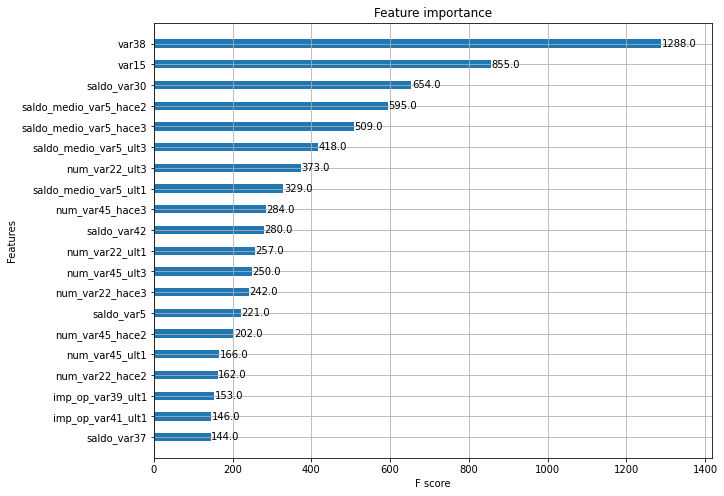

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

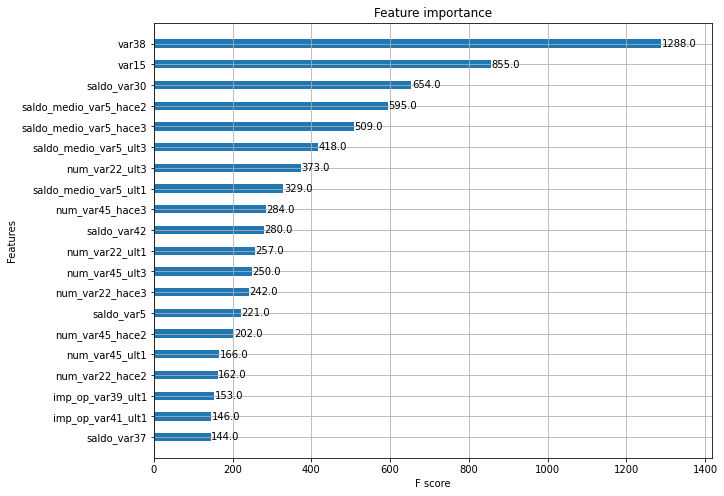

In [15]:
# 튜닝된 모델에서 각 피처의 중요도를 피처 중요도 그래프로 표시
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize = (10, 8))
plot_importance(xgb_clf, ax = ax, max_num_features = 20, height = 0.4)

## 3. LightGBM 모델 학습과 하이퍼 파라미터 튜닝
- 앞에서 만들어진 데이터 세트를 기반으로 LightGBM으로 학습을 수행하고, ROC-AUC 측정
- n_estimators = 500, early_stopping_rounds = 100, 평가 데이터 테스트는 테스트 데이터 세트, eval_metric은 auc로 설정한다.

In [16]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators = 500)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds = 100, eval_metric = 'auc', eval_set = evals, verbose = True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:, 1], average = 'macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.817384	valid_0's binary_logloss: 0.165046
[2]	valid_0's auc: 0.818903	valid_0's binary_logloss: 0.160006
[3]	valid_0's auc: 0.827707	valid_0's binary_logloss: 0.156323
[4]	valid_0's auc: 0.832155	valid_0's binary_logloss: 0.153463
[5]	valid_0's auc: 0.834677	valid_0's binary_logloss: 0.151256
[6]	valid_0's auc: 0.834093	valid_0's binary_logloss: 0.149427
[7]	valid_0's auc: 0.837046	valid_0's binary_logloss: 0.147961
[8]	valid_0's auc: 0.837838	valid_0's binary_logloss: 0.146591
[9]	valid_0's auc: 0.839435	valid_0's binary_logloss: 0.145455
[10]	valid_0's auc: 0.83973	valid_0's binary_logloss: 0.144486
[11]	valid_0's auc: 0.839799	valid_0's binary_logloss: 0.143769
[12]	valid_0's auc: 0.840034	valid_0's binary_logloss: 0.143146
[13]	valid_0's auc: 0.840271	valid_0's binary_logloss: 0.142533
[14]	valid_0's auc: 0.840342	valid_0's binary_logloss: 0.142036
[15]	valid_0's auc: 0.840928	valid_0's binary_logloss: 0.14161
[16]	valid_0's auc: 0.840337	valid_0's binary_loglo

In [ ]:
# GridSearchCV를 이용해 다양한 하이퍼 파라미터에 대한 튜닝 수행
# 튜닝 대상은 num_leaves, max_depth, min_child_samples, subsample
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 200으로 감소
lgbm_clf = LGBMClassifier(n_estimators = 200)

params = {'num_leaves' : [32, 64],
          'max_depth' : [128, 160],
          'min_child_samples' : [60, 1000],
          'subsample' : [0.8, 1]}

# cv는 3으로 지정
gridcv = GridSearchCV(lgbm_clf, param_grid = params, cv = 3)
gridcv.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric = 'auc',
           eval_set = [(X_train, y_train), (X_test, y_test)])

print('GridSearchCV 최적 파라미터:', gridcv.best_params_)
lgbm_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:, 1], average = 'macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.820235	valid_0's binary_logloss: 0.156085	valid_1's auc: 0.81613	valid_1's binary_logloss: 0.164992
[2]	valid_0's auc: 0.825778	valid_0's binary_logloss: 0.150951	valid_1's auc: 0.821835	valid_1's binary_logloss: 0.159874
[3]	valid_0's auc: 0.832262	valid_0's binary_logloss: 0.147158	valid_1's auc: 0.826533	valid_1's binary_logloss: 0.156346
[4]	valid_0's auc: 0.83865	valid_0's binary_logloss: 0.144126	valid_1's auc: 0.833166	valid_1's binary_logloss: 0.1534
[5]	valid_0's auc: 0.842822	valid_0's binary_logloss: 0.141725	valid_1's auc: 0.836448	valid_1's binary_logloss: 0.151167
[6]	valid_0's auc: 0.844702	valid_0's binary_logloss: 0.139642	valid_1's auc: 0.837094	valid_1's binary_logloss: 0.149356
[7]	valid_0's auc: 0.847144	valid_0's binary_logloss: 0.13794	valid_1's auc: 0.837965	valid_1's binary_logloss: 0.147853
[8]	valid_0's auc: 0.848277	valid_0's binary_logloss: 0.136499	valid_1's auc: 0.837663	valid_1's binary_logloss: 0.146543
[9]	valid_0's auc: 0.849328	v

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.814371	valid_0's binary_logloss: 0.156452	valid_1's auc: 0.813175	valid_1's binary_logloss: 0.165418
[2]	valid_0's auc: 0.827277	valid_0's binary_logloss: 0.151084	valid_1's auc: 0.819635	valid_1's binary_logloss: 0.160159
[3]	valid_0's auc: 0.837033	valid_0's binary_logloss: 0.14722	valid_1's auc: 0.828221	valid_1's binary_logloss: 0.156492
[4]	valid_0's auc: 0.840167	valid_0's binary_logloss: 0.14423	valid_1's auc: 0.830942	valid_1's binary_logloss: 0.153586
[5]	valid_0's auc: 0.842499	valid_0's binary_logloss: 0.141721	valid_1's auc: 0.833301	valid_1's binary_logloss: 0.151219
[6]	valid_0's auc: 0.845403	valid_0's binary_logloss: 0.139708	valid_1's auc: 0.836412	valid_1's binary_logloss: 0.149312
[7]	valid_0's auc: 0.848049	valid_0's binary_logloss: 0.138024	valid_1's auc: 0.836054	valid_1's binary_logloss: 0.14779
[8]	valid_0's auc: 0.849694	valid_0's binary_logloss: 0.136542	valid_1's auc: 0.837537	valid_1's binary_logloss: 0.146417
[9]	valid_0's auc: 0.851646

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.821645	valid_0's binary_logloss: 0.156528	valid_1's auc: 0.81857	valid_1's binary_logloss: 0.165101
[2]	valid_0's auc: 0.827488	valid_0's binary_logloss: 0.151189	valid_1's auc: 0.822299	valid_1's binary_logloss: 0.160072
[3]	valid_0's auc: 0.837855	valid_0's binary_logloss: 0.147263	valid_1's auc: 0.829855	valid_1's binary_logloss: 0.156527
[4]	valid_0's auc: 0.840063	valid_0's binary_logloss: 0.144261	valid_1's auc: 0.833088	valid_1's binary_logloss: 0.153446
[5]	valid_0's auc: 0.842802	valid_0's binary_logloss: 0.141691	valid_1's auc: 0.834541	valid_1's binary_logloss: 0.151144
[6]	valid_0's auc: 0.844	valid_0's binary_logloss: 0.139654	valid_1's auc: 0.834542	valid_1's binary_logloss: 0.149333
[7]	valid_0's auc: 0.845838	valid_0's binary_logloss: 0.138002	valid_1's auc: 0.835645	valid_1's binary_logloss: 0.147676
[8]	valid_0's auc: 0.846869	valid_0's binary_logloss: 0.136628	valid_1's auc: 0.836118	valid_1's binary_logloss: 0.146491
[9]	valid_0's auc: 0.849282	

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.820235	valid_0's binary_logloss: 0.156085	valid_1's auc: 0.81613	valid_1's binary_logloss: 0.164992
[2]	valid_0's auc: 0.825778	valid_0's binary_logloss: 0.150951	valid_1's auc: 0.821835	valid_1's binary_logloss: 0.159874
[3]	valid_0's auc: 0.832262	valid_0's binary_logloss: 0.147158	valid_1's auc: 0.826533	valid_1's binary_logloss: 0.156346
[4]	valid_0's auc: 0.83865	valid_0's binary_logloss: 0.144126	valid_1's auc: 0.833166	valid_1's binary_logloss: 0.1534
[5]	valid_0's auc: 0.842822	valid_0's binary_logloss: 0.141725	valid_1's auc: 0.836448	valid_1's binary_logloss: 0.151167
[6]	valid_0's auc: 0.844702	valid_0's binary_logloss: 0.139642	valid_1's auc: 0.837094	valid_1's binary_logloss: 0.149356
[7]	valid_0's auc: 0.847144	valid_0's binary_logloss: 0.13794	valid_1's auc: 0.837965	valid_1's binary_logloss: 0.147853
[8]	valid_0's auc: 0.848277	valid_0's binary_logloss: 0.136499	valid_1's auc: 0.837663	valid_1's binary_logloss: 0.146543
[9]	valid_0's auc: 0.849328	v

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.814371	valid_0's binary_logloss: 0.156452	valid_1's auc: 0.813175	valid_1's binary_logloss: 0.165418
[2]	valid_0's auc: 0.827277	valid_0's binary_logloss: 0.151084	valid_1's auc: 0.819635	valid_1's binary_logloss: 0.160159
[3]	valid_0's auc: 0.837033	valid_0's binary_logloss: 0.14722	valid_1's auc: 0.828221	valid_1's binary_logloss: 0.156492
[4]	valid_0's auc: 0.840167	valid_0's binary_logloss: 0.14423	valid_1's auc: 0.830942	valid_1's binary_logloss: 0.153586
[5]	valid_0's auc: 0.842499	valid_0's binary_logloss: 0.141721	valid_1's auc: 0.833301	valid_1's binary_logloss: 0.151219
[6]	valid_0's auc: 0.845403	valid_0's binary_logloss: 0.139708	valid_1's auc: 0.836412	valid_1's binary_logloss: 0.149312
[7]	valid_0's auc: 0.848049	valid_0's binary_logloss: 0.138024	valid_1's auc: 0.836054	valid_1's binary_logloss: 0.14779
[8]	valid_0's auc: 0.849694	valid_0's binary_logloss: 0.136542	valid_1's auc: 0.837537	valid_1's binary_logloss: 0.146417
[9]	valid_0's auc: 0.851646

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.821645	valid_0's binary_logloss: 0.156528	valid_1's auc: 0.81857	valid_1's binary_logloss: 0.165101
[2]	valid_0's auc: 0.827488	valid_0's binary_logloss: 0.151189	valid_1's auc: 0.822299	valid_1's binary_logloss: 0.160072
[3]	valid_0's auc: 0.837855	valid_0's binary_logloss: 0.147263	valid_1's auc: 0.829855	valid_1's binary_logloss: 0.156527
[4]	valid_0's auc: 0.840063	valid_0's binary_logloss: 0.144261	valid_1's auc: 0.833088	valid_1's binary_logloss: 0.153446
[5]	valid_0's auc: 0.842802	valid_0's binary_logloss: 0.141691	valid_1's auc: 0.834541	valid_1's binary_logloss: 0.151144
[6]	valid_0's auc: 0.844	valid_0's binary_logloss: 0.139654	valid_1's auc: 0.834542	valid_1's binary_logloss: 0.149333
[7]	valid_0's auc: 0.845838	valid_0's binary_logloss: 0.138002	valid_1's auc: 0.835645	valid_1's binary_logloss: 0.147676
[8]	valid_0's auc: 0.846869	valid_0's binary_logloss: 0.136628	valid_1's auc: 0.836118	valid_1's binary_logloss: 0.146491
[9]	valid_0's auc: 0.849282	

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.832891	valid_0's binary_logloss: 0.155302	valid_1's auc: 0.818851	valid_1's binary_logloss: 0.164826
[2]	valid_0's auc: 0.84519	valid_0's binary_logloss: 0.149727	valid_1's auc: 0.827144	valid_1's binary_logloss: 0.159879
[3]	valid_0's auc: 0.848018	valid_0's binary_logloss: 0.145627	valid_1's auc: 0.826851	valid_1's binary_logloss: 0.15631
[4]	valid_0's auc: 0.851096	valid_0's binary_logloss: 0.142423	valid_1's auc: 0.83073	valid_1's binary_logloss: 0.1534
[5]	valid_0's auc: 0.854735	valid_0's binary_logloss: 0.139746	valid_1's auc: 0.832753	valid_1's binary_logloss: 0.151136
[6]	valid_0's auc: 0.856928	valid_0's binary_logloss: 0.137509	valid_1's auc: 0.835605	valid_1's binary_logloss: 0.14924
[7]	valid_0's auc: 0.859448	valid_0's binary_logloss: 0.135575	valid_1's auc: 0.835612	valid_1's binary_logloss: 0.147799
[8]	valid_0's auc: 0.861685	valid_0's binary_logloss: 0.133953	valid_1's auc: 0.834408	valid_1's binary_logloss: 0.146634
[9]	valid_0's auc: 0.863391	va

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.833054	valid_0's binary_logloss: 0.15572	valid_1's auc: 0.817048	valid_1's binary_logloss: 0.165036
[2]	valid_0's auc: 0.841397	valid_0's binary_logloss: 0.149862	valid_1's auc: 0.82157	valid_1's binary_logloss: 0.159575
[3]	valid_0's auc: 0.849058	valid_0's binary_logloss: 0.145662	valid_1's auc: 0.829866	valid_1's binary_logloss: 0.155774
[4]	valid_0's auc: 0.854301	valid_0's binary_logloss: 0.142356	valid_1's auc: 0.832415	valid_1's binary_logloss: 0.152936
[5]	valid_0's auc: 0.858045	valid_0's binary_logloss: 0.139697	valid_1's auc: 0.834554	valid_1's binary_logloss: 0.150635
[6]	valid_0's auc: 0.860767	valid_0's binary_logloss: 0.137458	valid_1's auc: 0.834885	valid_1's binary_logloss: 0.148761
[7]	valid_0's auc: 0.863011	valid_0's binary_logloss: 0.135522	valid_1's auc: 0.835812	valid_1's binary_logloss: 0.147245
[8]	valid_0's auc: 0.864923	valid_0's binary_logloss: 0.133792	valid_1's auc: 0.836656	valid_1's binary_logloss: 0.145923
[9]	valid_0's auc: 0.86570

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.830643	valid_0's binary_logloss: 0.155759	valid_1's auc: 0.816734	valid_1's binary_logloss: 0.164985
[2]	valid_0's auc: 0.839353	valid_0's binary_logloss: 0.149977	valid_1's auc: 0.822571	valid_1's binary_logloss: 0.159808
[3]	valid_0's auc: 0.847366	valid_0's binary_logloss: 0.145866	valid_1's auc: 0.829312	valid_1's binary_logloss: 0.156171
[4]	valid_0's auc: 0.850911	valid_0's binary_logloss: 0.14247	valid_1's auc: 0.830848	valid_1's binary_logloss: 0.153328
[5]	valid_0's auc: 0.854674	valid_0's binary_logloss: 0.139764	valid_1's auc: 0.833041	valid_1's binary_logloss: 0.151023
[6]	valid_0's auc: 0.856722	valid_0's binary_logloss: 0.1375	valid_1's auc: 0.834264	valid_1's binary_logloss: 0.149166
[7]	valid_0's auc: 0.858253	valid_0's binary_logloss: 0.135713	valid_1's auc: 0.834998	valid_1's binary_logloss: 0.147631
[8]	valid_0's auc: 0.859768	valid_0's binary_logloss: 0.134063	valid_1's auc: 0.835678	valid_1's binary_logloss: 0.146384
[9]	valid_0's auc: 0.86262	

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.832891	valid_0's binary_logloss: 0.155302	valid_1's auc: 0.818851	valid_1's binary_logloss: 0.164826
[2]	valid_0's auc: 0.84519	valid_0's binary_logloss: 0.149727	valid_1's auc: 0.827144	valid_1's binary_logloss: 0.159879
[3]	valid_0's auc: 0.848018	valid_0's binary_logloss: 0.145627	valid_1's auc: 0.826851	valid_1's binary_logloss: 0.15631
[4]	valid_0's auc: 0.851096	valid_0's binary_logloss: 0.142423	valid_1's auc: 0.83073	valid_1's binary_logloss: 0.1534
[5]	valid_0's auc: 0.854735	valid_0's binary_logloss: 0.139746	valid_1's auc: 0.832753	valid_1's binary_logloss: 0.151136
[6]	valid_0's auc: 0.856928	valid_0's binary_logloss: 0.137509	valid_1's auc: 0.835605	valid_1's binary_logloss: 0.14924
[7]	valid_0's auc: 0.859448	valid_0's binary_logloss: 0.135575	valid_1's auc: 0.835612	valid_1's binary_logloss: 0.147799
[8]	valid_0's auc: 0.861685	valid_0's binary_logloss: 0.133953	valid_1's auc: 0.834408	valid_1's binary_logloss: 0.146634
[9]	valid_0's auc: 0.863391	va

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.833054	valid_0's binary_logloss: 0.15572	valid_1's auc: 0.817048	valid_1's binary_logloss: 0.165036
[2]	valid_0's auc: 0.841397	valid_0's binary_logloss: 0.149862	valid_1's auc: 0.82157	valid_1's binary_logloss: 0.159575
[3]	valid_0's auc: 0.849058	valid_0's binary_logloss: 0.145662	valid_1's auc: 0.829866	valid_1's binary_logloss: 0.155774
[4]	valid_0's auc: 0.854301	valid_0's binary_logloss: 0.142356	valid_1's auc: 0.832415	valid_1's binary_logloss: 0.152936
[5]	valid_0's auc: 0.858045	valid_0's binary_logloss: 0.139697	valid_1's auc: 0.834554	valid_1's binary_logloss: 0.150635
[6]	valid_0's auc: 0.860767	valid_0's binary_logloss: 0.137458	valid_1's auc: 0.834885	valid_1's binary_logloss: 0.148761
[7]	valid_0's auc: 0.863011	valid_0's binary_logloss: 0.135522	valid_1's auc: 0.835812	valid_1's binary_logloss: 0.147245
[8]	valid_0's auc: 0.864923	valid_0's binary_logloss: 0.133792	valid_1's auc: 0.836656	valid_1's binary_logloss: 0.145923
[9]	valid_0's auc: 0.86570

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.830643	valid_0's binary_logloss: 0.155759	valid_1's auc: 0.816734	valid_1's binary_logloss: 0.164985
[2]	valid_0's auc: 0.839353	valid_0's binary_logloss: 0.149977	valid_1's auc: 0.822571	valid_1's binary_logloss: 0.159808
[3]	valid_0's auc: 0.847366	valid_0's binary_logloss: 0.145866	valid_1's auc: 0.829312	valid_1's binary_logloss: 0.156171
[4]	valid_0's auc: 0.850911	valid_0's binary_logloss: 0.14247	valid_1's auc: 0.830848	valid_1's binary_logloss: 0.153328
[5]	valid_0's auc: 0.854674	valid_0's binary_logloss: 0.139764	valid_1's auc: 0.833041	valid_1's binary_logloss: 0.151023
[6]	valid_0's auc: 0.856722	valid_0's binary_logloss: 0.1375	valid_1's auc: 0.834264	valid_1's binary_logloss: 0.149166
[7]	valid_0's auc: 0.858253	valid_0's binary_logloss: 0.135713	valid_1's auc: 0.834998	valid_1's binary_logloss: 0.147631
[8]	valid_0's auc: 0.859768	valid_0's binary_logloss: 0.134063	valid_1's auc: 0.835678	valid_1's binary_logloss: 0.146384
[9]	valid_0's auc: 0.86262	

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.828278	valid_0's binary_logloss: 0.157377	valid_1's auc: 0.812691	valid_1's binary_logloss: 0.165808
[2]	valid_0's auc: 0.831547	valid_0's binary_logloss: 0.152726	valid_1's auc: 0.817669	valid_1's binary_logloss: 0.160974
[3]	valid_0's auc: 0.832877	valid_0's binary_logloss: 0.149366	valid_1's auc: 0.819325	valid_1's binary_logloss: 0.157499
[4]	valid_0's auc: 0.835274	valid_0's binary_logloss: 0.146775	valid_1's auc: 0.82281	valid_1's binary_logloss: 0.154844
[5]	valid_0's auc: 0.835913	valid_0's binary_logloss: 0.144697	valid_1's auc: 0.823398	valid_1's binary_logloss: 0.152773
[6]	valid_0's auc: 0.836609	valid_0's binary_logloss: 0.142992	valid_1's auc: 0.824209	valid_1's binary_logloss: 0.151086
[7]	valid_0's auc: 0.838138	valid_0's binary_logloss: 0.141473	valid_1's auc: 0.826949	valid_1's binary_logloss: 0.149455
[8]	valid_0's auc: 0.838744	valid_0's binary_logloss: 0.140234	valid_1's auc: 0.827917	valid_1's binary_logloss: 0.148179
[9]	valid_0's auc: 0.8393

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.830203	valid_0's binary_logloss: 0.157548	valid_1's auc: 0.8196	valid_1's binary_logloss: 0.165821
[2]	valid_0's auc: 0.833087	valid_0's binary_logloss: 0.1529	valid_1's auc: 0.820858	valid_1's binary_logloss: 0.161039
[3]	valid_0's auc: 0.835832	valid_0's binary_logloss: 0.14954	valid_1's auc: 0.8235	valid_1's binary_logloss: 0.157532
[4]	valid_0's auc: 0.837285	valid_0's binary_logloss: 0.146955	valid_1's auc: 0.827078	valid_1's binary_logloss: 0.154806
[5]	valid_0's auc: 0.83754	valid_0's binary_logloss: 0.144834	valid_1's auc: 0.829084	valid_1's binary_logloss: 0.152557
[6]	valid_0's auc: 0.838259	valid_0's binary_logloss: 0.143122	valid_1's auc: 0.829931	valid_1's binary_logloss: 0.150828
[7]	valid_0's auc: 0.839358	valid_0's binary_logloss: 0.14155	valid_1's auc: 0.83084	valid_1's binary_logloss: 0.149199
[8]	valid_0's auc: 0.840396	valid_0's binary_logloss: 0.140264	valid_1's auc: 0.832332	valid_1's binary_logloss: 0.147854
[9]	valid_0's auc: 0.84061	valid_0

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.829773	valid_0's binary_logloss: 0.157576	valid_1's auc: 0.822005	valid_1's binary_logloss: 0.165681
[2]	valid_0's auc: 0.832149	valid_0's binary_logloss: 0.152988	valid_1's auc: 0.823912	valid_1's binary_logloss: 0.16092
[3]	valid_0's auc: 0.833111	valid_0's binary_logloss: 0.14966	valid_1's auc: 0.823861	valid_1's binary_logloss: 0.157455
[4]	valid_0's auc: 0.835362	valid_0's binary_logloss: 0.146891	valid_1's auc: 0.825004	valid_1's binary_logloss: 0.154648
[5]	valid_0's auc: 0.836252	valid_0's binary_logloss: 0.144779	valid_1's auc: 0.827313	valid_1's binary_logloss: 0.152416
[6]	valid_0's auc: 0.837924	valid_0's binary_logloss: 0.142931	valid_1's auc: 0.827817	valid_1's binary_logloss: 0.150608
[7]	valid_0's auc: 0.838581	valid_0's binary_logloss: 0.141468	valid_1's auc: 0.828295	valid_1's binary_logloss: 0.149117
[8]	valid_0's auc: 0.839064	valid_0's binary_logloss: 0.140205	valid_1's auc: 0.829112	valid_1's binary_logloss: 0.147887
[9]	valid_0's auc: 0.83966

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.828278	valid_0's binary_logloss: 0.157377	valid_1's auc: 0.812691	valid_1's binary_logloss: 0.165808
[2]	valid_0's auc: 0.831547	valid_0's binary_logloss: 0.152726	valid_1's auc: 0.817669	valid_1's binary_logloss: 0.160974
[3]	valid_0's auc: 0.832877	valid_0's binary_logloss: 0.149366	valid_1's auc: 0.819325	valid_1's binary_logloss: 0.157499
[4]	valid_0's auc: 0.835274	valid_0's binary_logloss: 0.146775	valid_1's auc: 0.82281	valid_1's binary_logloss: 0.154844
[5]	valid_0's auc: 0.835913	valid_0's binary_logloss: 0.144697	valid_1's auc: 0.823398	valid_1's binary_logloss: 0.152773
[6]	valid_0's auc: 0.836609	valid_0's binary_logloss: 0.142992	valid_1's auc: 0.824209	valid_1's binary_logloss: 0.151086
[7]	valid_0's auc: 0.838138	valid_0's binary_logloss: 0.141473	valid_1's auc: 0.826949	valid_1's binary_logloss: 0.149455
[8]	valid_0's auc: 0.838744	valid_0's binary_logloss: 0.140234	valid_1's auc: 0.827917	valid_1's binary_logloss: 0.148179
[9]	valid_0's auc: 0.8393

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.830203	valid_0's binary_logloss: 0.157548	valid_1's auc: 0.8196	valid_1's binary_logloss: 0.165821
[2]	valid_0's auc: 0.833087	valid_0's binary_logloss: 0.1529	valid_1's auc: 0.820858	valid_1's binary_logloss: 0.161039
[3]	valid_0's auc: 0.835832	valid_0's binary_logloss: 0.14954	valid_1's auc: 0.8235	valid_1's binary_logloss: 0.157532
[4]	valid_0's auc: 0.837285	valid_0's binary_logloss: 0.146955	valid_1's auc: 0.827078	valid_1's binary_logloss: 0.154806
[5]	valid_0's auc: 0.83754	valid_0's binary_logloss: 0.144834	valid_1's auc: 0.829084	valid_1's binary_logloss: 0.152557
[6]	valid_0's auc: 0.838259	valid_0's binary_logloss: 0.143122	valid_1's auc: 0.829931	valid_1's binary_logloss: 0.150828
[7]	valid_0's auc: 0.839358	valid_0's binary_logloss: 0.14155	valid_1's auc: 0.83084	valid_1's binary_logloss: 0.149199
[8]	valid_0's auc: 0.840396	valid_0's binary_logloss: 0.140264	valid_1's auc: 0.832332	valid_1's binary_logloss: 0.147854
[9]	valid_0's auc: 0.84061	valid_0

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.829773	valid_0's binary_logloss: 0.157576	valid_1's auc: 0.822005	valid_1's binary_logloss: 0.165681
[2]	valid_0's auc: 0.832149	valid_0's binary_logloss: 0.152988	valid_1's auc: 0.823912	valid_1's binary_logloss: 0.16092
[3]	valid_0's auc: 0.833111	valid_0's binary_logloss: 0.14966	valid_1's auc: 0.823861	valid_1's binary_logloss: 0.157455
[4]	valid_0's auc: 0.835362	valid_0's binary_logloss: 0.146891	valid_1's auc: 0.825004	valid_1's binary_logloss: 0.154648
[5]	valid_0's auc: 0.836252	valid_0's binary_logloss: 0.144779	valid_1's auc: 0.827313	valid_1's binary_logloss: 0.152416
[6]	valid_0's auc: 0.837924	valid_0's binary_logloss: 0.142931	valid_1's auc: 0.827817	valid_1's binary_logloss: 0.150608
[7]	valid_0's auc: 0.838581	valid_0's binary_logloss: 0.141468	valid_1's auc: 0.828295	valid_1's binary_logloss: 0.149117
[8]	valid_0's auc: 0.839064	valid_0's binary_logloss: 0.140205	valid_1's auc: 0.829112	valid_1's binary_logloss: 0.147887
[9]	valid_0's auc: 0.83966

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.828278	valid_0's binary_logloss: 0.157377	valid_1's auc: 0.812691	valid_1's binary_logloss: 0.165808
[2]	valid_0's auc: 0.831547	valid_0's binary_logloss: 0.152726	valid_1's auc: 0.817669	valid_1's binary_logloss: 0.160974
[3]	valid_0's auc: 0.832877	valid_0's binary_logloss: 0.149366	valid_1's auc: 0.819325	valid_1's binary_logloss: 0.157499
[4]	valid_0's auc: 0.835274	valid_0's binary_logloss: 0.146775	valid_1's auc: 0.82281	valid_1's binary_logloss: 0.154844
[5]	valid_0's auc: 0.835913	valid_0's binary_logloss: 0.144697	valid_1's auc: 0.823398	valid_1's binary_logloss: 0.152773
[6]	valid_0's auc: 0.836609	valid_0's binary_logloss: 0.142992	valid_1's auc: 0.824209	valid_1's binary_logloss: 0.151086
[7]	valid_0's auc: 0.838138	valid_0's binary_logloss: 0.141473	valid_1's auc: 0.826949	valid_1's binary_logloss: 0.149455
[8]	valid_0's auc: 0.838744	valid_0's binary_logloss: 0.140234	valid_1's auc: 0.827917	valid_1's binary_logloss: 0.148179
[9]	valid_0's auc: 0.8393

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.830203	valid_0's binary_logloss: 0.157548	valid_1's auc: 0.8196	valid_1's binary_logloss: 0.165821
[2]	valid_0's auc: 0.833087	valid_0's binary_logloss: 0.1529	valid_1's auc: 0.820858	valid_1's binary_logloss: 0.161039
[3]	valid_0's auc: 0.835842	valid_0's binary_logloss: 0.14954	valid_1's auc: 0.8235	valid_1's binary_logloss: 0.157532
[4]	valid_0's auc: 0.837285	valid_0's binary_logloss: 0.146955	valid_1's auc: 0.827078	valid_1's binary_logloss: 0.154806
[5]	valid_0's auc: 0.83754	valid_0's binary_logloss: 0.144834	valid_1's auc: 0.829084	valid_1's binary_logloss: 0.152557
[6]	valid_0's auc: 0.838259	valid_0's binary_logloss: 0.143122	valid_1's auc: 0.829931	valid_1's binary_logloss: 0.150828
[7]	valid_0's auc: 0.839358	valid_0's binary_logloss: 0.14155	valid_1's auc: 0.83084	valid_1's binary_logloss: 0.149199
[8]	valid_0's auc: 0.8404	valid_0's binary_logloss: 0.140264	valid_1's auc: 0.832332	valid_1's binary_logloss: 0.147854
[9]	valid_0's auc: 0.840615	valid_0'

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.829773	valid_0's binary_logloss: 0.157576	valid_1's auc: 0.822005	valid_1's binary_logloss: 0.165681
[2]	valid_0's auc: 0.832149	valid_0's binary_logloss: 0.152988	valid_1's auc: 0.823912	valid_1's binary_logloss: 0.16092
[3]	valid_0's auc: 0.833111	valid_0's binary_logloss: 0.14966	valid_1's auc: 0.823861	valid_1's binary_logloss: 0.157455
[4]	valid_0's auc: 0.835362	valid_0's binary_logloss: 0.146891	valid_1's auc: 0.825004	valid_1's binary_logloss: 0.154648
[5]	valid_0's auc: 0.836252	valid_0's binary_logloss: 0.144779	valid_1's auc: 0.827313	valid_1's binary_logloss: 0.152416
[6]	valid_0's auc: 0.837923	valid_0's binary_logloss: 0.14293	valid_1's auc: 0.827814	valid_1's binary_logloss: 0.150608
[7]	valid_0's auc: 0.8386	valid_0's binary_logloss: 0.141468	valid_1's auc: 0.828241	valid_1's binary_logloss: 0.149117
[8]	valid_0's auc: 0.839079	valid_0's binary_logloss: 0.140205	valid_1's auc: 0.82911	valid_1's binary_logloss: 0.147887
[9]	valid_0's auc: 0.839675	va

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.828278	valid_0's binary_logloss: 0.157377	valid_1's auc: 0.812691	valid_1's binary_logloss: 0.165808
[2]	valid_0's auc: 0.831547	valid_0's binary_logloss: 0.152726	valid_1's auc: 0.817669	valid_1's binary_logloss: 0.160974
[3]	valid_0's auc: 0.832877	valid_0's binary_logloss: 0.149366	valid_1's auc: 0.819325	valid_1's binary_logloss: 0.157499
[4]	valid_0's auc: 0.835274	valid_0's binary_logloss: 0.146775	valid_1's auc: 0.82281	valid_1's binary_logloss: 0.154844
[5]	valid_0's auc: 0.835913	valid_0's binary_logloss: 0.144697	valid_1's auc: 0.823398	valid_1's binary_logloss: 0.152773
[6]	valid_0's auc: 0.836609	valid_0's binary_logloss: 0.142992	valid_1's auc: 0.824209	valid_1's binary_logloss: 0.151086
[7]	valid_0's auc: 0.838138	valid_0's binary_logloss: 0.141473	valid_1's auc: 0.826949	valid_1's binary_logloss: 0.149455
[8]	valid_0's auc: 0.838744	valid_0's binary_logloss: 0.140234	valid_1's auc: 0.827917	valid_1's binary_logloss: 0.148179
[9]	valid_0's auc: 0.8393

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.830203	valid_0's binary_logloss: 0.157548	valid_1's auc: 0.8196	valid_1's binary_logloss: 0.165821
[2]	valid_0's auc: 0.833087	valid_0's binary_logloss: 0.1529	valid_1's auc: 0.820858	valid_1's binary_logloss: 0.161039
[3]	valid_0's auc: 0.835842	valid_0's binary_logloss: 0.14954	valid_1's auc: 0.8235	valid_1's binary_logloss: 0.157532
[4]	valid_0's auc: 0.837285	valid_0's binary_logloss: 0.146955	valid_1's auc: 0.827078	valid_1's binary_logloss: 0.154806
[5]	valid_0's auc: 0.83754	valid_0's binary_logloss: 0.144834	valid_1's auc: 0.829084	valid_1's binary_logloss: 0.152557
[6]	valid_0's auc: 0.838259	valid_0's binary_logloss: 0.143122	valid_1's auc: 0.829931	valid_1's binary_logloss: 0.150828
[7]	valid_0's auc: 0.839358	valid_0's binary_logloss: 0.14155	valid_1's auc: 0.83084	valid_1's binary_logloss: 0.149199
[8]	valid_0's auc: 0.8404	valid_0's binary_logloss: 0.140264	valid_1's auc: 0.832332	valid_1's binary_logloss: 0.147854
[9]	valid_0's auc: 0.840615	valid_0'

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.829773	valid_0's binary_logloss: 0.157576	valid_1's auc: 0.822005	valid_1's binary_logloss: 0.165681
[2]	valid_0's auc: 0.832149	valid_0's binary_logloss: 0.152988	valid_1's auc: 0.823912	valid_1's binary_logloss: 0.16092
[3]	valid_0's auc: 0.833111	valid_0's binary_logloss: 0.14966	valid_1's auc: 0.823861	valid_1's binary_logloss: 0.157455
[4]	valid_0's auc: 0.835362	valid_0's binary_logloss: 0.146891	valid_1's auc: 0.825004	valid_1's binary_logloss: 0.154648
[5]	valid_0's auc: 0.836252	valid_0's binary_logloss: 0.144779	valid_1's auc: 0.827313	valid_1's binary_logloss: 0.152416
[6]	valid_0's auc: 0.837923	valid_0's binary_logloss: 0.14293	valid_1's auc: 0.827814	valid_1's binary_logloss: 0.150608
[7]	valid_0's auc: 0.8386	valid_0's binary_logloss: 0.141468	valid_1's auc: 0.828241	valid_1's binary_logloss: 0.149117
[8]	valid_0's auc: 0.839079	valid_0's binary_logloss: 0.140205	valid_1's auc: 0.82911	valid_1's binary_logloss: 0.147887
[9]	valid_0's auc: 0.839675	va

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.820235	valid_0's binary_logloss: 0.156085	valid_1's auc: 0.81613	valid_1's binary_logloss: 0.164992
[2]	valid_0's auc: 0.825778	valid_0's binary_logloss: 0.150951	valid_1's auc: 0.821835	valid_1's binary_logloss: 0.159874
[3]	valid_0's auc: 0.832262	valid_0's binary_logloss: 0.147158	valid_1's auc: 0.826533	valid_1's binary_logloss: 0.156346
[4]	valid_0's auc: 0.83865	valid_0's binary_logloss: 0.144126	valid_1's auc: 0.833166	valid_1's binary_logloss: 0.1534
[5]	valid_0's auc: 0.842822	valid_0's binary_logloss: 0.141725	valid_1's auc: 0.836448	valid_1's binary_logloss: 0.151167
[6]	valid_0's auc: 0.844702	valid_0's binary_logloss: 0.139642	valid_1's auc: 0.837094	valid_1's binary_logloss: 0.149356
[7]	valid_0's auc: 0.847144	valid_0's binary_logloss: 0.13794	valid_1's auc: 0.837965	valid_1's binary_logloss: 0.147853
[8]	valid_0's auc: 0.848277	valid_0's binary_logloss: 0.136499	valid_1's auc: 0.837663	valid_1's binary_logloss: 0.146543
[9]	valid_0's auc: 0.849328	v

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.814371	valid_0's binary_logloss: 0.156452	valid_1's auc: 0.813175	valid_1's binary_logloss: 0.165418
[2]	valid_0's auc: 0.827277	valid_0's binary_logloss: 0.151084	valid_1's auc: 0.819635	valid_1's binary_logloss: 0.160159
[3]	valid_0's auc: 0.837033	valid_0's binary_logloss: 0.14722	valid_1's auc: 0.828221	valid_1's binary_logloss: 0.156492
[4]	valid_0's auc: 0.840167	valid_0's binary_logloss: 0.14423	valid_1's auc: 0.830942	valid_1's binary_logloss: 0.153586
[5]	valid_0's auc: 0.842499	valid_0's binary_logloss: 0.141721	valid_1's auc: 0.833301	valid_1's binary_logloss: 0.151219
[6]	valid_0's auc: 0.845403	valid_0's binary_logloss: 0.139708	valid_1's auc: 0.836412	valid_1's binary_logloss: 0.149312
[7]	valid_0's auc: 0.848049	valid_0's binary_logloss: 0.138024	valid_1's auc: 0.836054	valid_1's binary_logloss: 0.14779
[8]	valid_0's auc: 0.849694	valid_0's binary_logloss: 0.136542	valid_1's auc: 0.837537	valid_1's binary_logloss: 0.146417
[9]	valid_0's auc: 0.851646

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.821645	valid_0's binary_logloss: 0.156528	valid_1's auc: 0.81857	valid_1's binary_logloss: 0.165101
[2]	valid_0's auc: 0.827488	valid_0's binary_logloss: 0.151189	valid_1's auc: 0.822299	valid_1's binary_logloss: 0.160072
[3]	valid_0's auc: 0.837855	valid_0's binary_logloss: 0.147263	valid_1's auc: 0.829855	valid_1's binary_logloss: 0.156527
[4]	valid_0's auc: 0.840063	valid_0's binary_logloss: 0.144261	valid_1's auc: 0.833088	valid_1's binary_logloss: 0.153446
[5]	valid_0's auc: 0.842802	valid_0's binary_logloss: 0.141691	valid_1's auc: 0.834541	valid_1's binary_logloss: 0.151144
[6]	valid_0's auc: 0.844	valid_0's binary_logloss: 0.139654	valid_1's auc: 0.834542	valid_1's binary_logloss: 0.149333
[7]	valid_0's auc: 0.845838	valid_0's binary_logloss: 0.138002	valid_1's auc: 0.835645	valid_1's binary_logloss: 0.147676
[8]	valid_0's auc: 0.846869	valid_0's binary_logloss: 0.136628	valid_1's auc: 0.836118	valid_1's binary_logloss: 0.146491
[9]	valid_0's auc: 0.849282	

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.820235	valid_0's binary_logloss: 0.156085	valid_1's auc: 0.81613	valid_1's binary_logloss: 0.164992
[2]	valid_0's auc: 0.825778	valid_0's binary_logloss: 0.150951	valid_1's auc: 0.821835	valid_1's binary_logloss: 0.159874
[3]	valid_0's auc: 0.832262	valid_0's binary_logloss: 0.147158	valid_1's auc: 0.826533	valid_1's binary_logloss: 0.156346
[4]	valid_0's auc: 0.83865	valid_0's binary_logloss: 0.144126	valid_1's auc: 0.833166	valid_1's binary_logloss: 0.1534
[5]	valid_0's auc: 0.842822	valid_0's binary_logloss: 0.141725	valid_1's auc: 0.836448	valid_1's binary_logloss: 0.151167
[6]	valid_0's auc: 0.844702	valid_0's binary_logloss: 0.139642	valid_1's auc: 0.837094	valid_1's binary_logloss: 0.149356
[7]	valid_0's auc: 0.847144	valid_0's binary_logloss: 0.13794	valid_1's auc: 0.837965	valid_1's binary_logloss: 0.147853
[8]	valid_0's auc: 0.848277	valid_0's binary_logloss: 0.136499	valid_1's auc: 0.837663	valid_1's binary_logloss: 0.146543
[9]	valid_0's auc: 0.849328	v

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.814371	valid_0's binary_logloss: 0.156452	valid_1's auc: 0.813175	valid_1's binary_logloss: 0.165418
[2]	valid_0's auc: 0.827277	valid_0's binary_logloss: 0.151084	valid_1's auc: 0.819635	valid_1's binary_logloss: 0.160159
[3]	valid_0's auc: 0.837033	valid_0's binary_logloss: 0.14722	valid_1's auc: 0.828221	valid_1's binary_logloss: 0.156492
[4]	valid_0's auc: 0.840167	valid_0's binary_logloss: 0.14423	valid_1's auc: 0.830942	valid_1's binary_logloss: 0.153586
[5]	valid_0's auc: 0.842499	valid_0's binary_logloss: 0.141721	valid_1's auc: 0.833301	valid_1's binary_logloss: 0.151219
[6]	valid_0's auc: 0.845403	valid_0's binary_logloss: 0.139708	valid_1's auc: 0.836412	valid_1's binary_logloss: 0.149312
[7]	valid_0's auc: 0.848049	valid_0's binary_logloss: 0.138024	valid_1's auc: 0.836054	valid_1's binary_logloss: 0.14779
[8]	valid_0's auc: 0.849694	valid_0's binary_logloss: 0.136542	valid_1's auc: 0.837537	valid_1's binary_logloss: 0.146417
[9]	valid_0's auc: 0.851646

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.821645	valid_0's binary_logloss: 0.156528	valid_1's auc: 0.81857	valid_1's binary_logloss: 0.165101
[2]	valid_0's auc: 0.827488	valid_0's binary_logloss: 0.151189	valid_1's auc: 0.822299	valid_1's binary_logloss: 0.160072
[3]	valid_0's auc: 0.837855	valid_0's binary_logloss: 0.147263	valid_1's auc: 0.829855	valid_1's binary_logloss: 0.156527
[4]	valid_0's auc: 0.840063	valid_0's binary_logloss: 0.144261	valid_1's auc: 0.833088	valid_1's binary_logloss: 0.153446
[5]	valid_0's auc: 0.842802	valid_0's binary_logloss: 0.141691	valid_1's auc: 0.834541	valid_1's binary_logloss: 0.151144
[6]	valid_0's auc: 0.844	valid_0's binary_logloss: 0.139654	valid_1's auc: 0.834542	valid_1's binary_logloss: 0.149333
[7]	valid_0's auc: 0.845838	valid_0's binary_logloss: 0.138002	valid_1's auc: 0.835645	valid_1's binary_logloss: 0.147676
[8]	valid_0's auc: 0.846869	valid_0's binary_logloss: 0.136628	valid_1's auc: 0.836118	valid_1's binary_logloss: 0.146491
[9]	valid_0's auc: 0.849282	

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.832891	valid_0's binary_logloss: 0.155302	valid_1's auc: 0.818851	valid_1's binary_logloss: 0.164826
[2]	valid_0's auc: 0.84519	valid_0's binary_logloss: 0.149727	valid_1's auc: 0.827144	valid_1's binary_logloss: 0.159879
[3]	valid_0's auc: 0.848018	valid_0's binary_logloss: 0.145627	valid_1's auc: 0.826851	valid_1's binary_logloss: 0.15631
[4]	valid_0's auc: 0.851096	valid_0's binary_logloss: 0.142423	valid_1's auc: 0.83073	valid_1's binary_logloss: 0.1534
[5]	valid_0's auc: 0.854735	valid_0's binary_logloss: 0.139746	valid_1's auc: 0.832753	valid_1's binary_logloss: 0.151136
[6]	valid_0's auc: 0.856928	valid_0's binary_logloss: 0.137509	valid_1's auc: 0.835605	valid_1's binary_logloss: 0.14924
[7]	valid_0's auc: 0.859448	valid_0's binary_logloss: 0.135575	valid_1's auc: 0.835612	valid_1's binary_logloss: 0.147799
[8]	valid_0's auc: 0.861685	valid_0's binary_logloss: 0.133953	valid_1's auc: 0.834408	valid_1's binary_logloss: 0.146634
[9]	valid_0's auc: 0.863391	va

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.833054	valid_0's binary_logloss: 0.15572	valid_1's auc: 0.817048	valid_1's binary_logloss: 0.165036
[2]	valid_0's auc: 0.841397	valid_0's binary_logloss: 0.149862	valid_1's auc: 0.82157	valid_1's binary_logloss: 0.159575
[3]	valid_0's auc: 0.849058	valid_0's binary_logloss: 0.145662	valid_1's auc: 0.829866	valid_1's binary_logloss: 0.155774
[4]	valid_0's auc: 0.854301	valid_0's binary_logloss: 0.142356	valid_1's auc: 0.832415	valid_1's binary_logloss: 0.152936
[5]	valid_0's auc: 0.858045	valid_0's binary_logloss: 0.139697	valid_1's auc: 0.834554	valid_1's binary_logloss: 0.150635
[6]	valid_0's auc: 0.860767	valid_0's binary_logloss: 0.137458	valid_1's auc: 0.834885	valid_1's binary_logloss: 0.148761
[7]	valid_0's auc: 0.863011	valid_0's binary_logloss: 0.135522	valid_1's auc: 0.835812	valid_1's binary_logloss: 0.147245
[8]	valid_0's auc: 0.864923	valid_0's binary_logloss: 0.133792	valid_1's auc: 0.836656	valid_1's binary_logloss: 0.145923
[9]	valid_0's auc: 0.86570

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.830643	valid_0's binary_logloss: 0.155759	valid_1's auc: 0.816734	valid_1's binary_logloss: 0.164985
[2]	valid_0's auc: 0.839353	valid_0's binary_logloss: 0.149977	valid_1's auc: 0.822571	valid_1's binary_logloss: 0.159808
[3]	valid_0's auc: 0.847366	valid_0's binary_logloss: 0.145866	valid_1's auc: 0.829312	valid_1's binary_logloss: 0.156171
[4]	valid_0's auc: 0.850911	valid_0's binary_logloss: 0.14247	valid_1's auc: 0.830848	valid_1's binary_logloss: 0.153328
[5]	valid_0's auc: 0.854674	valid_0's binary_logloss: 0.139764	valid_1's auc: 0.833041	valid_1's binary_logloss: 0.151023
[6]	valid_0's auc: 0.856722	valid_0's binary_logloss: 0.1375	valid_1's auc: 0.834264	valid_1's binary_logloss: 0.149166
[7]	valid_0's auc: 0.858253	valid_0's binary_logloss: 0.135713	valid_1's auc: 0.834998	valid_1's binary_logloss: 0.147631
[8]	valid_0's auc: 0.859768	valid_0's binary_logloss: 0.134063	valid_1's auc: 0.835678	valid_1's binary_logloss: 0.146384
[9]	valid_0's auc: 0.86262	

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.832891	valid_0's binary_logloss: 0.155302	valid_1's auc: 0.818851	valid_1's binary_logloss: 0.164826
[2]	valid_0's auc: 0.84519	valid_0's binary_logloss: 0.149727	valid_1's auc: 0.827144	valid_1's binary_logloss: 0.159879
[3]	valid_0's auc: 0.848018	valid_0's binary_logloss: 0.145627	valid_1's auc: 0.826851	valid_1's binary_logloss: 0.15631
[4]	valid_0's auc: 0.851096	valid_0's binary_logloss: 0.142423	valid_1's auc: 0.83073	valid_1's binary_logloss: 0.1534
[5]	valid_0's auc: 0.854735	valid_0's binary_logloss: 0.139746	valid_1's auc: 0.832753	valid_1's binary_logloss: 0.151136
[6]	valid_0's auc: 0.856928	valid_0's binary_logloss: 0.137509	valid_1's auc: 0.835605	valid_1's binary_logloss: 0.14924
[7]	valid_0's auc: 0.859448	valid_0's binary_logloss: 0.135575	valid_1's auc: 0.835612	valid_1's binary_logloss: 0.147799
[8]	valid_0's auc: 0.861685	valid_0's binary_logloss: 0.133953	valid_1's auc: 0.834408	valid_1's binary_logloss: 0.146634
[9]	valid_0's auc: 0.863391	va

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.833054	valid_0's binary_logloss: 0.15572	valid_1's auc: 0.817048	valid_1's binary_logloss: 0.165036
[2]	valid_0's auc: 0.841397	valid_0's binary_logloss: 0.149862	valid_1's auc: 0.82157	valid_1's binary_logloss: 0.159575
[3]	valid_0's auc: 0.849058	valid_0's binary_logloss: 0.145662	valid_1's auc: 0.829866	valid_1's binary_logloss: 0.155774
[4]	valid_0's auc: 0.854301	valid_0's binary_logloss: 0.142356	valid_1's auc: 0.832415	valid_1's binary_logloss: 0.152936
[5]	valid_0's auc: 0.858045	valid_0's binary_logloss: 0.139697	valid_1's auc: 0.834554	valid_1's binary_logloss: 0.150635
[6]	valid_0's auc: 0.860767	valid_0's binary_logloss: 0.137458	valid_1's auc: 0.834885	valid_1's binary_logloss: 0.148761
[7]	valid_0's auc: 0.863011	valid_0's binary_logloss: 0.135522	valid_1's auc: 0.835812	valid_1's binary_logloss: 0.147245
[8]	valid_0's auc: 0.864923	valid_0's binary_logloss: 0.133792	valid_1's auc: 0.836656	valid_1's binary_logloss: 0.145923
[9]	valid_0's auc: 0.86570

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.830643	valid_0's binary_logloss: 0.155759	valid_1's auc: 0.816734	valid_1's binary_logloss: 0.164985
[2]	valid_0's auc: 0.839353	valid_0's binary_logloss: 0.149977	valid_1's auc: 0.822571	valid_1's binary_logloss: 0.159808
[3]	valid_0's auc: 0.847366	valid_0's binary_logloss: 0.145866	valid_1's auc: 0.829312	valid_1's binary_logloss: 0.156171
[4]	valid_0's auc: 0.850911	valid_0's binary_logloss: 0.14247	valid_1's auc: 0.830848	valid_1's binary_logloss: 0.153328
[5]	valid_0's auc: 0.854674	valid_0's binary_logloss: 0.139764	valid_1's auc: 0.833041	valid_1's binary_logloss: 0.151023
[6]	valid_0's auc: 0.856722	valid_0's binary_logloss: 0.1375	valid_1's auc: 0.834264	valid_1's binary_logloss: 0.149166
[7]	valid_0's auc: 0.858253	valid_0's binary_logloss: 0.135713	valid_1's auc: 0.834998	valid_1's binary_logloss: 0.147631
[8]	valid_0's auc: 0.859768	valid_0's binary_logloss: 0.134063	valid_1's auc: 0.835678	valid_1's binary_logloss: 0.146384
[9]	valid_0's auc: 0.86262	

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.828278	valid_0's binary_logloss: 0.157377	valid_1's auc: 0.812691	valid_1's binary_logloss: 0.165808
[2]	valid_0's auc: 0.831547	valid_0's binary_logloss: 0.152726	valid_1's auc: 0.817669	valid_1's binary_logloss: 0.160974
[3]	valid_0's auc: 0.832877	valid_0's binary_logloss: 0.149366	valid_1's auc: 0.819325	valid_1's binary_logloss: 0.157499
[4]	valid_0's auc: 0.835274	valid_0's binary_logloss: 0.146775	valid_1's auc: 0.82281	valid_1's binary_logloss: 0.154844
[5]	valid_0's auc: 0.835913	valid_0's binary_logloss: 0.144697	valid_1's auc: 0.823398	valid_1's binary_logloss: 0.152773
[6]	valid_0's auc: 0.836609	valid_0's binary_logloss: 0.142992	valid_1's auc: 0.824209	valid_1's binary_logloss: 0.151086
[7]	valid_0's auc: 0.838138	valid_0's binary_logloss: 0.141473	valid_1's auc: 0.826949	valid_1's binary_logloss: 0.149455
[8]	valid_0's auc: 0.838744	valid_0's binary_logloss: 0.140234	valid_1's auc: 0.827917	valid_1's binary_logloss: 0.148179
[9]	valid_0's auc: 0.8393

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.830203	valid_0's binary_logloss: 0.157548	valid_1's auc: 0.8196	valid_1's binary_logloss: 0.165821
[2]	valid_0's auc: 0.833087	valid_0's binary_logloss: 0.1529	valid_1's auc: 0.820858	valid_1's binary_logloss: 0.161039
[3]	valid_0's auc: 0.835832	valid_0's binary_logloss: 0.14954	valid_1's auc: 0.8235	valid_1's binary_logloss: 0.157532
[4]	valid_0's auc: 0.837285	valid_0's binary_logloss: 0.146955	valid_1's auc: 0.827078	valid_1's binary_logloss: 0.154806
[5]	valid_0's auc: 0.83754	valid_0's binary_logloss: 0.144834	valid_1's auc: 0.829084	valid_1's binary_logloss: 0.152557
[6]	valid_0's auc: 0.838259	valid_0's binary_logloss: 0.143122	valid_1's auc: 0.829931	valid_1's binary_logloss: 0.150828
[7]	valid_0's auc: 0.839358	valid_0's binary_logloss: 0.14155	valid_1's auc: 0.83084	valid_1's binary_logloss: 0.149199
[8]	valid_0's auc: 0.840396	valid_0's binary_logloss: 0.140264	valid_1's auc: 0.832332	valid_1's binary_logloss: 0.147854
[9]	valid_0's auc: 0.84061	valid_0

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.829773	valid_0's binary_logloss: 0.157576	valid_1's auc: 0.822005	valid_1's binary_logloss: 0.165681
[2]	valid_0's auc: 0.832149	valid_0's binary_logloss: 0.152988	valid_1's auc: 0.823912	valid_1's binary_logloss: 0.16092
[3]	valid_0's auc: 0.833111	valid_0's binary_logloss: 0.14966	valid_1's auc: 0.823861	valid_1's binary_logloss: 0.157455
[4]	valid_0's auc: 0.835362	valid_0's binary_logloss: 0.146891	valid_1's auc: 0.825004	valid_1's binary_logloss: 0.154648
[5]	valid_0's auc: 0.836252	valid_0's binary_logloss: 0.144779	valid_1's auc: 0.827313	valid_1's binary_logloss: 0.152416
[6]	valid_0's auc: 0.837924	valid_0's binary_logloss: 0.142931	valid_1's auc: 0.827817	valid_1's binary_logloss: 0.150608
[7]	valid_0's auc: 0.838581	valid_0's binary_logloss: 0.141468	valid_1's auc: 0.828295	valid_1's binary_logloss: 0.149117
[8]	valid_0's auc: 0.839064	valid_0's binary_logloss: 0.140205	valid_1's auc: 0.829112	valid_1's binary_logloss: 0.147887
[9]	valid_0's auc: 0.83966

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.828278	valid_0's binary_logloss: 0.157377	valid_1's auc: 0.812691	valid_1's binary_logloss: 0.165808
[2]	valid_0's auc: 0.831547	valid_0's binary_logloss: 0.152726	valid_1's auc: 0.817669	valid_1's binary_logloss: 0.160974
[3]	valid_0's auc: 0.832877	valid_0's binary_logloss: 0.149366	valid_1's auc: 0.819325	valid_1's binary_logloss: 0.157499
[4]	valid_0's auc: 0.835274	valid_0's binary_logloss: 0.146775	valid_1's auc: 0.82281	valid_1's binary_logloss: 0.154844
[5]	valid_0's auc: 0.835913	valid_0's binary_logloss: 0.144697	valid_1's auc: 0.823398	valid_1's binary_logloss: 0.152773
[6]	valid_0's auc: 0.836609	valid_0's binary_logloss: 0.142992	valid_1's auc: 0.824209	valid_1's binary_logloss: 0.151086
[7]	valid_0's auc: 0.838138	valid_0's binary_logloss: 0.141473	valid_1's auc: 0.826949	valid_1's binary_logloss: 0.149455
[8]	valid_0's auc: 0.838744	valid_0's binary_logloss: 0.140234	valid_1's auc: 0.827917	valid_1's binary_logloss: 0.148179
[9]	valid_0's auc: 0.8393

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.830203	valid_0's binary_logloss: 0.157548	valid_1's auc: 0.8196	valid_1's binary_logloss: 0.165821
[2]	valid_0's auc: 0.833087	valid_0's binary_logloss: 0.1529	valid_1's auc: 0.820858	valid_1's binary_logloss: 0.161039
[3]	valid_0's auc: 0.835832	valid_0's binary_logloss: 0.14954	valid_1's auc: 0.8235	valid_1's binary_logloss: 0.157532
[4]	valid_0's auc: 0.837285	valid_0's binary_logloss: 0.146955	valid_1's auc: 0.827078	valid_1's binary_logloss: 0.154806
[5]	valid_0's auc: 0.83754	valid_0's binary_logloss: 0.144834	valid_1's auc: 0.829084	valid_1's binary_logloss: 0.152557
[6]	valid_0's auc: 0.838259	valid_0's binary_logloss: 0.143122	valid_1's auc: 0.829931	valid_1's binary_logloss: 0.150828
[7]	valid_0's auc: 0.839358	valid_0's binary_logloss: 0.14155	valid_1's auc: 0.83084	valid_1's binary_logloss: 0.149199
[8]	valid_0's auc: 0.840396	valid_0's binary_logloss: 0.140264	valid_1's auc: 0.832332	valid_1's binary_logloss: 0.147854
[9]	valid_0's auc: 0.84061	valid_0

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.829773	valid_0's binary_logloss: 0.157576	valid_1's auc: 0.822005	valid_1's binary_logloss: 0.165681
[2]	valid_0's auc: 0.832149	valid_0's binary_logloss: 0.152988	valid_1's auc: 0.823912	valid_1's binary_logloss: 0.16092
[3]	valid_0's auc: 0.833111	valid_0's binary_logloss: 0.14966	valid_1's auc: 0.823861	valid_1's binary_logloss: 0.157455
[4]	valid_0's auc: 0.835362	valid_0's binary_logloss: 0.146891	valid_1's auc: 0.825004	valid_1's binary_logloss: 0.154648
[5]	valid_0's auc: 0.836252	valid_0's binary_logloss: 0.144779	valid_1's auc: 0.827313	valid_1's binary_logloss: 0.152416


In [ ]:
lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, subsample = 0.8, min_child_samples = 60,
                          max_depth = 128)
evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds = 100, eval_metric = 'auc', eval_set = evals, verbose = True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:, 1], average = 'macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

# 분류 실습 - 캐글 신용카드 사기 검출
- 레이블 : Class
- Class = 1 : 신용카드 사기 트랜잭션
- Class = 0 : 정상적인 신용카드 트랜잭션
- 전체 데이터의 약 0.172%만이 레이블 값이 1, 즉 사기 트랜잭션이다.

### 언더 샘플링과 오버 샘플링의 이해
#### 배경
- 레이블이 불균형한 분포를 가진 데이터 세트를 학습시킬 때, 예측 성능의 문제가 발생한다.
- 이상 레이블을 가지는 데이터 건수는 매우 작기 때문에 제대로 다양한 유형을 학습하지 못하는 반면, 정상 레이블을 가지는 데이터 건수는 매우 많기 때문에 일방적으로 정상 레이블로 치우친 학습을 수행해 제대로 된 이상 데이터 검출이 어렵다.

#### 해결방안

- 지도학습에서 극도로 불균형한 레이블 값 분포로 인한 문제점을 해결하기 위해서는, 적절한 학습 데이터를 확보하는 방안이 필요하다.

#### 오버 샘플링 (Oversampling)
- 예측 성능상 더 유리한 경우가 많아 주로 사용
- 적은 데이터 세트를 증식하여 학습을 위한 충분한 데이터를 확보

#### SMOTE 방법
- 적은 데이터 세트의 개별 데이터들의 KNN을 찾아 이 데이터와 K개의 이웃들의 차이를 일정 값으로 만들어서 기존 데이터와 약간씩 차이가 나는 새로운 데이터들을 생성하는 방식

#### 언더 샘플링 (Undersampling)
- 많은 데이터 세트를 적은 데이터 세트 수준으로 감소
- 너무 많은 정상 레이블 데이터를 감소시키므로, 정상 레이블의 경우 오히려 제대로 된 학습을 수행할 수 없다는 단점